input1, input2 = vcf_base, vcf_comp
sv1, sv2 = svs in base, svs in comp (svtype, svlen, svpos)
bool sel1, sel2 = false (whether sv are tp in base and comp)

create another list grouped by svtype

foreach svtype:
  foreach sv in sv_comp:
    if sv.pos within range of any :
      sel_call[sv] = true
      
foreach svtype:
  foreach sv in sv_base:
    if sv.pos within range:
      sel_base[sv] = true

tp_call = cnt(sel_call == true)
tp_base = cnt(sel_base == true)

fp = len(sv1) - tp_call
fn = len(sv2) - tp_base

precision, recall, f1 = ...

In [14]:
import collections
import os
import shutil
import numpy as np
import itertools
import operator
import copy
import statistics
import sklearn
from sklearn import tree
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib import rcParams

In [15]:
def init_chrom_list():
    chrom = []
    chrom_list = []
    for i in range(1, 23):
        chrom_list.append(str(i))
    chrom_list.append('X')
    chrom_list.append('Y')
    return(chrom_list)

In [16]:
def read_file(vcf_path):
    with open(vcf_path, 'r') as file:
        raw = file.readlines()
    raw = [s.strip() for s in raw]
    raw = [s.split() for s in raw]
    return raw

In [17]:
def parse_vcf(vcf_file, support_reads_file = ''):
    chrom_list = init_chrom_list()
    callset = read_file(vcf_file)
    call = [[] for ch in range(24)]
    for ch in range(24):
        call[ch] = [s for s in callset if s[0] == 'chr' + chrom_list[ch]]
        if call[ch] == []:
            continue
        info = [s[7].split(';') for s in call[ch]]
    
        svlen = [[s2 for s2 in s if 'SVLEN=' in s2] for s in info]
        svlen = ['SVLEN=0' if s == [] or s[0] == 'SVLEN=.' else s[0] for s in svlen]    
        svlen = [int(s[7:]) if '>' in s else int(s[6:]) for s in svlen]
        call[ch] = [call[ch][i] + [svlen[i]] for i in range(len(call[ch]))]

        svtype = [[s2 for s2 in s if 'SVTYPE=' in s2][0][7:] for s in info]
        call[ch] = [call[ch][i] + [svtype[i]] for i in range(len(call[ch]))]
    
        re = [[s2 for s2 in s if any(x in s2 for x in ['SUPPORT=', 'SR=', 'RE='])] for s in info]
        if re[0] != []:
            if 'SUPPORT=' in re[0][0]:
                re = [int(s[0][8:]) for s in re]
                call[ch] = [call[ch][i] + [re[i]] for i in range(len(call[ch]))]
            else:
                re = [int(s[0][3:]) for s in re]
                call[ch] = [call[ch][i] + [re[i]] for i in range(len(call[ch]))]

        rname = [[s2 for s2 in s if any(x in s2 for x in ['RNAMES=', 'READS='])] for s in info]
        if rname[0] != []:
            if 'RNAMES=' in rname[0][0]:
                rname = [s[0][7:].split(',') for s in rname]
                call[ch] = [call[ch][i] + [rname[i]] for i in range(len(call[ch]))]
            else:
                rname = [s[0][6:].split(',') for s in rname]
                call[ch] = [call[ch][i] + [rname[i]] for i in range(len(call[ch]))]
    
        if support_reads_file != '':
            raw_rname = read_file(support_reads_file)
            raw_rname = raw_rname[1:]
            nanovar_sv2read = dict()
            for s in raw_rname:
                nanovar_sv2read[s[0]] = {}
                tmp_reads = [s2[:s2.find('~')] for s2 in s[1].split(',') if len(s2) > 5]
                tmp_reads = list(dict.fromkeys(tmp_reads))
                nanovar_sv2read[s[0]] = tmp_reads
            call[ch] = [call[ch][i] + [nanovar_sv2read[call[ch][i][2]]] for i in range(len(call[ch]))]
            
        gtinfo = [s[9].split(':') for s in call[ch]]
        if len(gtinfo[0]) > 4: # gt ref var
            call[ch] = [call[ch][i] + [gtinfo[i][0]] for i in range(len(call[ch]))]
            call[ch] = [call[ch][i] + [int(gtinfo[i][1]) if gtinfo[i][1] != '.' else 0] \
                        for i in range(len(call[ch]))]
            call[ch] = [call[ch][i] + [int(gtinfo[i][2]) if gtinfo[i][2] != '.' else 0] \
                        for i in range(len(call[ch]))]
        elif len(gtinfo[0]) >= 3:
            call[ch] = [call[ch][i] + [gtinfo[i][0]] for i in range(len(call[ch]))]
            if gtinfo[0][-1].find(',') == -1:
                call[ch] = [call[ch][i] + [int(gtinfo[i][1]) if gtinfo[i][1] != '.' else 0] \
                            for i in range(len(call[ch]))]
                call[ch] = [call[ch][i] + [int(gtinfo[i][2]) if gtinfo[i][2] != '.' else 0] \
                            for i in range(len(call[ch]))]
            else:
                call[ch] = [call[ch][i] + [int(gtinfo[i][-1][:gtinfo[i][-1].find(',')]) \
                            if gtinfo[i][-1][:gtinfo[i][-1].find(',')] != '.' else 0] \
                            for i in range(len(call[ch]))]
                call[ch] = [call[ch][i] + [int(gtinfo[i][-1][gtinfo[i][-1].find(',') + 1:]) \
                            if gtinfo[i][-1][gtinfo[i][-1].find(',') + 1:] != '.' else 0] \
                            for i in range(len(call[ch]))]
    return(call)

In [18]:
def calc_tps(comp_call, base_call, svlen, re_supp):

    # comp_call_sel = [[s for s in ch if abs(int(s[-2])) > 49] for ch in comp_call] # nanosv
    comp_call_sel = [[s for s in ch if abs(int(s[10])) >= svlen and s[12] >= re_supp] for ch in comp_call] # all other
    base_call_sel = [[s for s in ch if abs(int(s[10])) >= svlen] for ch in base_call]
    
    # ins include INS and DUP (svim)
    comp_ins = [[[int(s[1]), s[10], s[9], s[2]] for s in comp_call_sel[ch] if s[11] in ['INS', 'DUP', 'DUP:TANDEM', 'DUP:INT']] for ch in range(24)]
    comp_del = [[[int(s[1]), abs(s[10]), s[9], s[2]] for s in comp_call_sel[ch] if s[11] in ['DEL']] for ch in range(24)]
    base_ins = [[[int(s[1]), s[10], s[9], s[2]] for s in base_call_sel[ch] if s[11] in ['INS', 'DUP']] for ch in range(24)]
    base_del = [[[int(s[1]), abs(s[10]), s[9], s[2]] for s in base_call_sel[ch] if s[11] in ['DEL']] for ch in range(24)]
    
    tp_bool_comp_ins = [[False for s in ch] for ch in comp_ins]
    tp_bool_comp_del = [[False for s in ch] for ch in comp_del]
    tp_bool_base_ins = [[False for s in ch] for ch in base_ins]
    tp_bool_base_del = [[False for s in ch] for ch in base_del]
    ps_comp_ins = [[] for ch in range(24)]
    ps_comp_del = [[] for ch in range(24)]
    tp_idx_comp_ins = [[] for ch in range(24)]
    tp_idx_comp_del = [[] for ch in range(24)]

    # ins, del for comp, base
    thres = 1001 # tp if within thres 1000
    # comp ins
    for ch in range(24):
        pos1 = [s[0] for s in base_ins[ch]]
        pos2 = [s[0] for s in comp_ins[ch]]
        tru_phase = [s[2] for s in base_ins[ch]]
        sv_name = [s[3] for s in base_ins[ch]]
        idx = np.searchsorted(pos1, pos2) # map pos2 to pos1
        if len(comp_ins[ch]) > 0 and len(base_ins[ch]) > 0:
            idx_closest = [max(idx[i] - 1, 0) if abs(pos2[i] - pos1[max(idx[i] - 1, 0)]) < \
                          abs(pos2[i] - pos1[min(idx[i], len(pos1) - 1)]) else min(idx[i], len(pos1) - 1) \
                          for i in range(len(pos2))]
            tp_bool_comp_ins[ch] = [abs(pos2[i] - pos1[idx_closest[i]]) < thres \
                                    for i in range(len(pos2))]
            ps_comp_ins[ch] = [tru_phase[idx_closest[i]] if tp_bool_comp_ins[ch][i] else '' \
                              for i in range(len(pos2))]
            tp_idx_comp_ins[ch] = [sv_name[idx_closest[i]] if tp_bool_comp_ins[ch][i] else '' \
                                  for i in range(len(pos2))]
            
        idx = np.searchsorted(pos2, pos1) # map pos1 to pos2
        if len(comp_ins[ch]) > 0 and len(base_ins[ch]) > 0:
            tp_bool_base_ins[ch] = [abs(pos1[i] - pos2[max(idx[i] - 1, 0)]) < thres or \
                                    abs(pos1[i] - pos2[min(idx[i], len(pos2) - 1)]) < thres \
                                    for i in range(len(pos1))]
    
        pos1 = [s[0] for s in base_del[ch]]
        pos2 = [s[0] for s in comp_del[ch]]
        tru_phase = [s[2] for s in base_del[ch]]
        sv_name = [s[3] for s in base_del[ch]]
                               
        idx = np.searchsorted(pos1, pos2) # map pos2 to pos1
        if len(comp_del[ch]) > 0 and len(base_del[ch]) > 0:
            idx_closest = [max(idx[i] - 1, 0) if abs(pos2[i] - pos1[max(idx[i] - 1, 0)]) < \
                          abs(pos2[i] - pos1[min(idx[i], len(pos1) - 1)]) else min(idx[i], len(pos1) - 1) \
                          for i in range(len(pos2))]
            tp_bool_comp_del[ch] = [abs(pos2[i] - pos1[idx_closest[i]]) < thres \
                                    for i in range(len(pos2))]
            ps_comp_del[ch] = [tru_phase[idx_closest[i]] if tp_bool_comp_del[ch][i] else '' \
                              for i in range(len(pos2))]
            tp_idx_comp_del[ch] = [sv_name[idx_closest[i]] if tp_bool_comp_del[ch][i] else '' \
                                  for i in range(len(pos2))]
                               
        idx = np.searchsorted(pos2, pos1) # map pos1 to pos2
        if len(comp_del[ch]) > 0 and len(base_del[ch]) > 0:
            tp_bool_base_del[ch] = [abs(pos1[i] - pos2[max(idx[i] - 1, 0)]) < thres or \
                                    abs(pos1[i] - pos2[min(idx[i], len(pos2) - 1)]) < thres \
                                    for i in range(len(pos1))]
                               
    for ch in range(24):
        ind_ins = ind_del = -1
        for ind in range(len(comp_call[ch])):
            if comp_call[ch][ind][11] in ['INS', 'DUP', 'DUP:TANDEM', 'DUP:INT'] and \
               abs(int(comp_call[ch][ind][10])) >= svlen and comp_call[ch][ind][12] >= re_supp:
                ind_ins += 1
                comp_call[ch][ind].append(tp_bool_comp_ins[ch][ind_ins])
                comp_call[ch][ind].append(ps_comp_ins[ch][ind_ins])
                comp_call[ch][ind].append(tp_idx_comp_ins[ch][ind_ins])
            elif comp_call[ch][ind][11] in ['DEL'] and \
                 abs(int(comp_call[ch][ind][10])) >= svlen and comp_call[ch][ind][12] >= re_supp:
                ind_del += 1
                comp_call[ch][ind].append(tp_bool_comp_del[ch][ind_del])
                comp_call[ch][ind].append(ps_comp_del[ch][ind_del])
                comp_call[ch][ind].append(tp_idx_comp_del[ch][ind_del])
                               
    return(tp_bool_base_del, tp_bool_base_ins, tp_bool_comp_del, tp_bool_comp_ins, comp_call)

In [19]:
def calc_f1(tp_base_all, tp_comp_all):  
    totcall_base = len(tp_base_all)
    totcall_comp = len(tp_comp_all)
    tottp_base = sum(s == True for s in tp_base_all)
    tottp_comp = sum(s == True for s in tp_comp_all)
    precision = tottp_comp / totcall_comp
    recall = tottp_base / totcall_base
    f1 = 2 * precision * recall / (precision + recall)
    return(precision, recall, f1)

In [20]:
def read_hap_bam(path):
    read_hap = [[] for ch in range(24)]
    chrom_list = init_chrom_list()
    
    for ch in range(24):
        read_hap[ch] = dict()
        hap_bam_path = path + 'chr' + chrom_list[ch] + '.sam'
        aln_info = [[s[0], int(s[1]), int(s[3]), int(s[4]), int(s[-3][5:]), int(s[-2][5:]), int(s[-1][5:])] \
                        for s in read_file(hap_bam_path) if 'PC:i:' in s[-2]]
        for item in aln_info:
            read_hap[ch][item[0]] = {'hap': item[-3], 'ps': item[-1], 'pc': item[-2]}
    return read_hap

In [21]:
def generate_baseinfo(base_path):
    base_call = parse_vcf(base_vcf_path)
    callset = []
    for ch in range(24):
        for c in range(len(base_call[ch])):
            callset.append(dict())
            t = len(callset) - 1
            callset[t]['raw'] = base_call[ch][c][:10]
            callset[t]['chrom'] = base_call[ch][c][0]
            callset[t]['pos'] = int(base_call[ch][c][1])
            callset[t]['baseid'] = base_call[ch][c][2]
            callset[t]['svlen'] = abs(base_call[ch][c][10])
            callset[t]['svtype'] = base_call[ch][c][11]
            callset[t]['gt'] = base_call[ch][c][9]
    return callset

In [22]:
def generate_callinfo(caller, read_hap):
    if caller == 'nanovar':
        comp_call = parse_vcf(caller_path[caller], nanovar_rname_path)
    else:
        comp_call = parse_vcf(caller_path[caller])
    
    for ch in range(24):
        for call in comp_call[ch]:
            call[13] = [[s, read_hap[ch][s]['hap'], read_hap[ch][s]['ps'], read_hap[ch][s]['pc']] \
                        if s in read_hap[ch] else [s] for s in call[13]]
        
    _, _, _, _, comp_call = calc_tps(comp_call, parse_vcf(base_vcf_path), 0, 0)
    
    callset = []
    for ch in range(24):
        for c in range(len(comp_call[ch])):
            callset.append(dict())
            t = len(callset) - 1
            callset[t]['raw'] = comp_call[ch][c][:10]
            callset[t]['chrom'] = comp_call[ch][c][0]
            callset[t]['pos'] = int(comp_call[ch][c][1])
            callset[t]['callid'] = comp_call[ch][c][2]
            callset[t]['qual'] = comp_call[ch][c][5]
            callset[t]['filt'] = comp_call[ch][c][6]
        
            callset[t]['svlen'] = abs(comp_call[ch][c][10])
            callset[t]['svtype'] = comp_call[ch][c][11]
            callset[t]['svreadinfo'] = comp_call[ch][c][13]
            callset[t]['svread'] = comp_call[ch][c][12]
        
            callset[t]['callgt'] = comp_call[ch][c][14]
            callset[t]['refread'] = comp_call[ch][c][15]
            if len(comp_call[ch][c]) > 17:
                callset[t]['basegt'] = comp_call[ch][c][18]
                callset[t]['baseid'] = comp_call[ch][c][19]
    return callset

In [23]:
# bench normal SV calling & genotyping
def normal_gt_bench(callset, baseset, suppread_thres = 2, svlen_thres = 50, rmnogt = True, gt = True):
    compset = [c for c in callset if 'baseid' in c and \
               c['svread'] >= suppread_thres and c['svlen'] >= svlen_thres]
    if rmnogt:
        compset = [c for c in compset if c['callgt'] not in ['0/0', './.']]        
    if gt:
        tp11 = [c['callgt'] == '1/1' and c['basegt'] in ['1|1', '.|1'] for c in compset]
        tp01 = [c['callgt'] == '0/1' and c['basegt'] in ['0|1', '1|0', '.|1'] for c in compset]
        tp = [tp11[c] or tp01[c] for c in range(len(compset))]
        tot_base = set([compset[c]['baseid'] for c in range(len(tp)) if tp[c]])
        tot_call = sum(call for call in tp)
        p = tot_call / len(compset)
        r = len(tot_base) / len(baseset)
        f1 = 2 * p * r / (p + r)
    else:
        p = len([c for c in compset if c['baseid'] != '']) / len(compset)
        r = len(set(c['baseid'] for c in compset if c['baseid'] != '')) / len(baseset)
        f1 = 2 * p * r / (p + r)

    print(caller, p, r, f1)

In [24]:
# bench SV calling & genotyping based on likelihood
def likelihood_gt_bench(callset, baseset, suppread_thres = 2, svlen_thres = 50, eps = 0.9):
    compset = [c for c in callset if 'baseid' in c and c['callgt'] != './.' and \
               c['svread'] >= suppread_thres and c['svlen'] >= svlen_thres]
    all_call = tot_call = 0
    tot_base = set()
    for c in compset:
        pred = 0
        l00 = (1 - eps) ** c['svread'] * eps ** c['refread']
        l11 = (1 - eps) ** c['refread'] * eps ** c['svread']
#         l01 = 0.5 ** (c['refread'] + c['svread'])
        
        l01 = (1 - eps) ** (abs(c['svread'] - c['refread']) / 2) * \
              eps ** (c['svread'] + c['refread'] - abs(c['svread'] - c['refread']) / 2)
        
        if l01 > l11 and l01 > l00:
            pred = 1
        elif l11 > l01 and l11 > l00:
            pred = 2
        
        if (pred == 1 and c['basegt'] in ['0|1', '1|0', '.|1']) or pred == 2 and c['basegt'] in ['1|1', '.|1']:
            tot_call += 1
            tot_base.add(c['baseid'])
        if pred in [1, 2]:
            all_call += 1
    
    p = tot_call / all_call
    r = len(tot_base) / len(baseset)
    f1 = 2 * p * r / (p + r)

    print(caller, p, r, f1)

In [25]:
# bench normal SV phasing
def normal_phase_bench(callset, baseset, suppread_thres = 2, svlen_thres = 50, ps_sr = 2, pc_cutoff = 100000):
    compset = [c for c in callset if 'baseid' in c and c['svlen'] >= svlen_thres \
               and c['svread'] >= suppread_thres and c['callgt'] not in ['./.']]

    callset_oneps = [c for c in compset if len(set([s[2] for s in c['svreadinfo'] if len(s) > 1])) == 1]
    callset_multips = [c for c in compset if len(set([s[2] for s in c['svreadinfo'] if len(s) > 1])) > 1]
    callset_nops = [c for c in compset if len(set([s[2] for s in c['svreadinfo'] if len(s) > 1])) == 0]
    oneps_set = [set() for ch in range(24)]
    eva_callset_ch = [[] for ch in range(24)]
    callset_size = 0
    chrom_list = init_chrom_list()
    for ch in range(24):
        callset_ch = [c for c in callset_oneps if c['chrom'] == 'chr' + chrom_list[ch]]
        for c in callset_ch:
            hap1 = hap2 = tothap = 0
            for read in c['svreadinfo']:
                if len(read) > 1 and read[3] <= pc_cutoff:
                    ps = read[2]
                    if read[1] == 1:
                        hap1 += 1
                    elif read[1] == 2:
                        hap2 += 1
            if hap1 >= ps_sr:
                tothap += 1
            if hap2 >= ps_sr:
                tothap += 2

#             if c['svread'] / (c['refread'] + c['svread']) >= 0.8 and c['svread'] > 1:
#                 tothap = 3
            
            if tothap > 0:
                callset_size += 1
                oneps_set[ch].add(ps)
                eva_callset_ch[ch].append([ps, tothap, c['baseid'], c['basegt'], c])
            
    tp_ps = []
    fp_ps = []
    pred_tp = []
    pred_fp = []
    tot_call = num_ps = 0
    tot_base = set()
    for ch in range(24):
        for ps in oneps_set[ch]:
            eva = [c for c in eva_callset_ch[ch] if c[0] == ps]
            tp11 = [call[1] == 3 and call[3] == '1|1' for call in eva]
            tp01_1 = [call[1] == 1 and call[3] == '0|1' for call in eva]
            tp10_1 = [call[1] == 2 and call[3] == '1|0' for call in eva]
            tp1_1 = [call[1] in [3, 1] and call[3] == '.|1' for call in eva]
            tp01_2 = [call[1] == 2 and call[3] == '0|1' for call in eva]
            tp10_2 = [call[1] == 1 and call[3] == '1|0' for call in eva]
            tp1_2 = [call[1] in [3, 2] and call[3] == '.|1' for call in eva]
            tp2 = [tp11[c] or tp01_2[c] or tp10_2[c] or tp1_2[c] for c in range(len(eva))]
            tp1 = [tp11[c] or tp01_1[c] or tp10_1[c] or tp1_1[c] for c in range(len(eva))]
            if sum([call for call in tp1]) > sum([call for call in tp2]):
                tp_call = tp1
            else:
                tp_call = tp2
            tot_base = tot_base.union([eva[c][2] for c in range(len(tp_call)) if tp_call[c]])
            tot_call += sum(call for call in tp_call)
            
            tp_ps += [eva[c][4] for c in range(len(eva)) if tp_call[c]]
            fp_ps += [eva[c][4] for c in range(len(eva)) if not tp_call[c]]
            
            pred_tp += [eva[c][1] for c in range(len(eva)) if tp_call[c]]
            pred_fp += [eva[c][1] for c in range(len(eva)) if not tp_call[c]]
            
            if len(eva) > 0:
                num_ps += 1
        
    p = tot_call / callset_size
    r = len(tot_base) / len(baseset)
    f1 = 2 * p * r / (p + r)
    avg_sv_num_ps = callset_size / num_ps

    print(caller, p, r, f1, avg_sv_num_ps)

In [26]:
def get_phase_info(call, ps_sr = 2, ps_num = 1, oneps_set = ''):
    info = dict()
    info['hap1'] = info['hap2'] = info['tothap'] = info['hap1_totsc'] = info['allhap'] \
    = info['hap2_totsc'] = info['hap1_avgsc'] = info['hap2_avgsc'] = info['ps'] = info['hap0'] = 0
    if ps_num == 1:
        for read in call['svreadinfo']:
            if len(read) > 1 and read[3] <= 8100: # maybe no cut-off: len(read) > 1 and read[3] <= 3000
                info['ps'] = read[2]
                if read[1] == 1:
                    info['hap1'] += 1
                    info['hap1_totsc'] += read[3]
                elif read[1] == 2:
                    info['hap2'] += 1
                    info['hap2_totsc'] += read[3]
        info['hap0'], info['allhap'] = 0, info['hap1'] + info['hap2']
    if ps_num == 2:
        ps_dict = dict()
        for read in call['svreadinfo']:
            if len(read) > 1 and read[3] <= 8100: # maybe no cut-off: len(read) > 1 and read[3] <= 3000
                info['allhap'] += 1
                ps = read[2]
                if ps in oneps_set:
                    if ps not in ps_dict:
                        ps_dict[ps] = dict()
                        ps_dict[ps][0] = ps_dict[ps][1] = ps_dict[ps][2] = ps_dict[ps]['1_score'] = \
                        ps_dict[ps]['2_score'] = 0 
                    ps_dict[ps][read[1]] += 1
                    ps_dict[ps][str(read[1]) + '_score'] += read[3]
                    ps_dict[ps][0] += 1
        max_tot = 0
        for ps in ps_dict:
            if ps_dict[ps][0] > max_tot:
                max_tot = ps_dict[ps][0]
                info['hap1'], info['hap1_totsc'], info['hap2'], info['hap2_totsc'], info['ps'] = \
                ps_dict[ps][1], ps_dict[ps]['1_score'], ps_dict[ps][2], ps_dict[ps]['2_score'], ps
                info['hap0'] = info['allhap'] - info['hap1'] - info['hap2']
    if ps_num == 0 or info['hap1'] == info['hap2'] == 0:
        oneps_ls = np.sort(np.array(list(oneps_set)))
        idx = np.searchsorted(oneps_ls, call['pos']) # map pos to ls
        idx = max(idx - 1, 0) if abs(call['pos'] - oneps_ls[max(idx - 1, 0)]) < \
              abs(call['pos'] - oneps_ls[min(idx, len(oneps_ls) - 1)]) else min(idx, len(oneps_ls) - 1)
        info['ps'] = oneps_ls[idx]
    info['hapread_ratio'] = info['allhap'] / len(call['svreadinfo'])
    if info['hap1'] > 0:
        info['hap1_avgsc'] = info['hap1_totsc'] / info['hap1']
    if info['hap2'] > 0:
        info['hap2_avgsc'] = info['hap2_totsc'] / info['hap2']
    if info['hap1'] >= ps_sr:
        info['tothap'] += 1
    if info['hap2'] >= ps_sr:
        info['tothap'] += 2
    info['nohap'] = len(call['svreadinfo']) - info['allhap']
    info['hap_diff'] = abs(info['hap1'] - info['hap2'])
    info['sv_ratio'] = call['svread'] / (call['svread'] + call['refread'])
    info['totsc_ratio'] = max(info['hap1_totsc'], info['hap2_totsc']) / min(info['hap1_totsc'], info['hap2_totsc']) \
                          if min(info['hap1_totsc'], info['hap2_totsc']) > 0 else 0
    info['onehap_totsc'] = max(info['hap1_totsc'], info['hap2_totsc']) if \
                           min(info['hap1_totsc'], info['hap2_totsc']) == 0 else 0
    info['avgsc_ratio'] = max(info['hap1_avgsc'], info['hap2_avgsc']) / min(info['hap1_avgsc'], info['hap2_avgsc']) \
                          if min(info['hap1_avgsc'], info['hap2_avgsc']) > 0 else 0
    info['onehap_avgsc'] = max(info['hap1_avgsc'], info['hap2_avgsc']) if \
                           min(info['hap1_avgsc'], info['hap2_avgsc']) == 0 else 0
    info['hap_avgsc_diff'] = abs(info['hap2_avgsc'] - info['hap1_avgsc'])
    info['hap_totsc_diff'] = abs(info['hap2_totsc'] - info['hap1_totsc'])
    info['ref_num'] = call['refread']
    info['sv_num'] = call['svread']
    info['allsv'] = len(call['svreadinfo'])
    info['hap_ratio'] = max(info['hap1'], info['hap2']) / max(min(info['hap1'], info['hap2']), 1)
    info['totsc'] = info['hap1_totsc'] + info['hap2_totsc']
    info['totsc_ratio2'] = max(info['hap1_totsc'], info['hap2_totsc']) / info['totsc'] if info['totsc'] > 0 else 0
    return info

In [27]:
def predict_hp(call, ps_num, oneps_set):
    f = get_phase_info(call, 2, ps_num, oneps_set)
    pred = 0
    if ps_num == 0:
        if f['sv_ratio'] == 1 and f['sv_num'] >= 4:
            pred = 3
    elif ps_num == 2:
        if f['sv_ratio'] >= 0.72:
            if f['hap_avgsc_diff'] <= 1369.50:
                if f['sv_num'] >= 3:
                    pred = 3
            else:
                if f['hap0'] >= 6:
                    pred = 3
    elif ps_num == 1:
        if (f['hap1'] == 0 and f['hap2'] == 0) or f['sv_num'] >= 20:
            pred = 0
        if f['onehap_totsc'] != 0:
            if f['sv_ratio'] <= 0.24:
                pred = 0
            elif f['sv_ratio'] <= 0.9:
                if f['hapread_ratio'] <= 0.75 and f['hap_avgsc_diff'] <= 2400 or f['hapread_ratio'] > 0.75:
                    pred = 1 if f['hap1_avgsc'] > 0 else 2
            else:
                if f['hapread_ratio'] <= 0.75 and f['hap_avgsc_diff'] <= 2400 or f['hapread_ratio'] > 0.75:
                    pred = 3
        if f['onehap_totsc'] == 0:
            if f['sv_ratio'] <= 0.3:
                pred = 0
            elif f['sv_ratio'] <= 0.45:
                if f['ref_num'] > 10:
                    pred = 0
                else:
                    pred = 1 if f['hap1_totsc'] > f['hap2_totsc'] else 2
            elif f['sv_ratio'] <= 0.75:
                if f['totsc_ratio'] <= 9.72:
                    pred = 3
                else:
                    pred = 1 if f['hap1_totsc'] > f['hap2_totsc'] else 2
            else:
                pred = 3
                
    return pred, f['ps']

In [29]:
def bench_alter(callset, baseset):
    callset_dict = dict()
    callset_dict[1] = [c for c in callset if len(set([s[2] for s in c['svreadinfo'] if len(s) > 1])) == 1]
    callset_dict[2] = [c for c in callset if len(set([s[2] for s in c['svreadinfo'] if len(s) > 1])) > 1]
    callset_dict[0] = [c for c in callset if len(set([s[2] for s in c['svreadinfo'] if len(s) > 1])) == 0]
    callset_size = num_ps = tot_call_nogt = tot_call_gt = 0
    tot_base_nogt, tot_base_gt = set(), set()
    eva_callset_ch = [[] for ch in range(24)]
    oneps_set = [set() for ch in range(24)]
    for ch in range(24):
        callset_ch = [c for c in callset_dict[1] if c['chrom'] == 'chr' + chrom_list[ch]]
        for c in callset_ch:
            for read in c['svreadinfo']:
                if len(read) > 1 and read[3] <= 8100:
                    oneps_set[ch].add(read[2])
                    break
    hap_tot = dict()
    hap_tot[1] = hap_tot[2] = hap_tot[3] = 0
    for ch in range(24):
        for ps_num in range(3):
            callset_ch = [c for c in callset_dict[ps_num] if c['chrom'] == 'chr' + chrom_list[ch]]
            for c in callset_ch:
                pred, ps = predict_hp(c, ps_num, oneps_set[ch])
                if pred > 0:
                    callset_size += 1
                    eva_callset_ch[ch].append([ps, pred, c['baseid'], c['basegt'], c])
                    if (pred in [1, 2] and c['basegt'] in ['0|1', '1|0', '.|1']) or \
                        pred == 3 and c['basegt'] in ['1|1', '.|1']:
                        tot_call_gt += 1
                        tot_base_gt.add(c['baseid'])
                    if pred in [1, 2, 3] and c['basegt'] in ['0|1', '1|0', '.|1', '1|1']:
                        tot_call_nogt += 1
                        tot_base_nogt.add(c['baseid'])
                        
                    hap_tot[pred] += 1
                    
    tp_ps, fp_ps, pred_tp, pred_fp = [], [], [], []
    tot_call_ps = 0
    tot_base_ps = set()
    for ch in range(24):
        for ps in oneps_set[ch]:
            eva = [c for c in eva_callset_ch[ch] if c[0] == ps]
            tp11 = [call[1] == 3 and call[3] == '1|1' for call in eva]
            tp01_1 = [call[1] == 1 and call[3] == '0|1' for call in eva]
            tp10_1 = [call[1] == 2 and call[3] == '1|0' for call in eva]
            tp1_1 = [call[1] in [3, 1] and call[3] == '.|1' for call in eva]
            tp01_2 = [call[1] == 2 and call[3] == '0|1' for call in eva]
            tp10_2 = [call[1] == 1 and call[3] == '1|0' for call in eva]
            tp1_2 = [call[1] in [3, 2] and call[3] == '.|1' for call in eva]
            tp2 = [tp11[c] or tp01_2[c] or tp10_2[c] or tp1_2[c] for c in range(len(eva))]
            tp1 = [tp11[c] or tp01_1[c] or tp10_1[c] or tp1_1[c] for c in range(len(eva))]
            if sum([call for call in tp1]) > sum([call for call in tp2]):
                tp_call = tp1
            else:
                tp_call = tp2
            tot_base_ps = tot_base_ps.union([eva[c][2] for c in range(len(tp_call)) if tp_call[c]])
            tot_call_ps += sum(call for call in tp_call)
            if len(eva) > 0:
                num_ps += 1
    p = tot_call_ps / callset_size
    r = len(tot_base_ps) / len(baseset)
    f1 = 2 * p * r / (p + r)
    avg_sv_num_ps = callset_size / num_ps
    print('phasing', p, r, f1, avg_sv_num_ps)
    
    p = tot_call_gt / callset_size
    r = len(tot_base_gt) / len(baseset)
    f1 = 2 * p * r / (p + r)
    print('gt', p, r, f1)
    
    p = tot_call_nogt / callset_size
    r = len(tot_base_nogt) / len(baseset)
    f1 = 2 * p * r / (p + r)
    print('nogt', p, r, f1)
    
    print(hap_tot[1], hap_tot[2], hap_tot[3])

In [ ]:
# test performance wrt clair settings
callstat, readstat = dict(), dict()

sample = ['HG00733']
truth_home = '/autofs/bal20/ykzhou/truthset_vcf/HGSVC2/'
for sp in sample:
    sample_home = '/autofs/bal20/ykzhou/' + sp + '/'
    cutesv_path = sample_home + 'cutesv/cutesv.vcf'
    svim_cls09_path = sample_home + 'svim_cls09/variants.vcf'
    svim_path = sample_home + 'svim/variants.vcf'
    caller_path = {'cutesv': cutesv_path, 'svim_cls09': svim_cls09_path, 'svim': svim_path}
    callstat[sp] = dict()
    readstat[sp] = dict()
    base_vcf_path = truth_home + sp + '_mainChr.vcf'
    callstat[sp]['base'] = generate_baseinfo(base_vcf_path)
    for af in ['snp_8x_012/', 'snp_8x_015/', 'snp_8x_020/', 'snp_8x_025/', 'snp_8x_030/', 'snp_8x_037/']:
        snp_home = sample_home + af
        phase_home = snp_home + 'phase/'
        readstat[sp][af] = dict()
        callstat[sp][af] = dict()
        for partition in ['pileup/', 'all/']:
            partition_home = phase_home + partition
            readstat[sp][af][partition] = read_hap_bam(partition_home)
            callstat[sp][af][partition] = dict()
            for caller in caller_path:
                callstat[sp][af][partition][caller] = generate_callinfo(caller, readstat[sp][af][partition])

In [28]:
# test combination

callstat, readstat = dict(), dict()

sample = ['HG00733', 'NA12878', 'NA24385']
truth_home = '/autofs/bal20/ykzhou/truthset_vcf/HGSVC2/'
for sp in sample:
    sample_home = '/autofs/bal20/ykzhou/' + sp + '/'
    cutesv_path = sample_home + 'cutesv/cutesv.vcf'
    svim_cls09_path = sample_home + 'svim_cls09/variants.vcf'
    svim_path = sample_home + 'svim/variants.vcf'
    caller_path = {'cutesv': cutesv_path, 'svim_cls09': svim_cls09_path, 'svim': svim_path}
    callstat[sp] = dict()
    readstat[sp] = dict()
    base_vcf_path = truth_home + sp + '_mainChr.vcf'
    callstat[sp]['base'] = generate_baseinfo(base_vcf_path)
    for af in ['snp_8x_025/']:
        snp_home = sample_home + af
        phase_home = snp_home + 'phase/'
        readstat[sp][af] = dict()
        callstat[sp][af] = dict()
        for partition in ['pileup/']:
            partition_home = phase_home + partition
            readstat[sp][af][partition] = read_hap_bam(partition_home)
            callstat[sp][af][partition] = dict()
            for caller in caller_path:
                callstat[sp][af][partition][caller] = generate_callinfo(caller, readstat[sp][af][partition])

c1 = copy.deepcopy(callstat['HG00733']['snp_8x_025/']['pileup/']['svim_cls09'])
c2 = copy.deepcopy(callstat['NA24385']['snp_8x_025/']['pileup/']['svim_cls09'])
c3 = copy.deepcopy(callstat['NA12878']['snp_8x_025/']['pileup/']['svim_cls09'])
b1 = copy.deepcopy(callstat['HG00733']['base'])
b2 = copy.deepcopy(callstat['NA24385']['base'])
b3 = copy.deepcopy(callstat['NA12878']['base'])
for c in c1:
    c['callid'] += '_' + 'HG00733'
    if 'baseid' in c and c['baseid'] != '':
        c['baseid'] += '_' + 'HG00733'
for c in c2:
    c['callid'] += '_' + 'NA24385'
    if 'baseid' in c and c['baseid'] != '':
        c['baseid'] += '_' + 'NA24385'
for c in c3:
    c['callid'] += '_' + 'NA12878'
    if 'baseid' in c and c['baseid'] != '':
        c['baseid'] += '_' + 'NA12878'
        
for b in b1:
    b['baseid'] += '_' + 'HG00733'
for b in b1:
    b['baseid'] += '_' + 'NA24385'
for b in b1:
    b['baseid'] += '_' + 'NA12878'
    
callstat['combine_025_pileup_svimcls09'] = c1 + c2 + c3
callstat['combine_base'] = b1 + b2 + b3

c1 = copy.deepcopy(callstat['HG00733']['snp_8x_025/']['pileup/']['svim'])
c2 = copy.deepcopy(callstat['NA24385']['snp_8x_025/']['pileup/']['svim'])
c3 = copy.deepcopy(callstat['NA12878']['snp_8x_025/']['pileup/']['svim'])

for c in c1:
    c['callid'] += '_' + 'HG00733'
    if 'baseid' in c and c['baseid'] != '':
        c['baseid'] += '_' + 'HG00733'
for c in c2:
    c['callid'] += '_' + 'NA24385'
    if 'baseid' in c and c['baseid'] != '':
        c['baseid'] += '_' + 'NA24385'
for c in c3:
    c['callid'] += '_' + 'NA12878'
    if 'baseid' in c and c['baseid'] != '':
        c['baseid'] += '_' + 'NA12878'
        
callstat['combine_025_pileup_svim'] = c1 + c2 + c3

c1 = copy.deepcopy(callstat['HG00733']['snp_8x_025/']['pileup/']['cutesv'])
c2 = copy.deepcopy(callstat['NA24385']['snp_8x_025/']['pileup/']['cutesv'])
c3 = copy.deepcopy(callstat['NA12878']['snp_8x_025/']['pileup/']['cutesv'])

for c in c1:
    c['callid'] += '_' + 'HG00733'
    if 'baseid' in c and c['baseid'] != '':
        c['baseid'] += '_' + 'HG00733'
for c in c2:
    c['callid'] += '_' + 'NA24385'
    if 'baseid' in c and c['baseid'] != '':
        c['baseid'] += '_' + 'NA24385'
for c in c3:
    c['callid'] += '_' + 'NA12878'
    if 'baseid' in c and c['baseid'] != '':
        c['baseid'] += '_' + 'NA12878'
        
callstat['combine_025_pileup_cutesv'] = c1 + c2 + c3

In [103]:
# pileup:
# 15: 4h
# 20: 3h
# 25: 1.5h

callset = callstat['combine_025_pileup_svim']
baseset = callstat['combine_base']
    
normal_gt_bench(callset, baseset, 2, 50, False, False)
normal_gt_bench(callset, baseset, 2, 50, True, True)
#             likelihood_gt_bench(callset, baseset, eps = 0.9) # eps > 0.5 is the same
normal_phase_bench(callset, baseset, 2, 50, 2, 1000000)

svim 0.8375455583963445 0.8048879955722567 0.8208921013202433
svim 0.6122356666289721 0.6212822977657374 0.6167258081628911
svim 0.5259846896238094 0.5376940778933263 0.5317749330156212 9.527259598026237


0.5860223990381069 0.5927 0.5934195476989126 0.5934249843622871 (6300), 0.5937297844748278 (7200)
7800 low
8100 
8400 low
9000 low

cutesv
0.8081361080820684
0.6680156986346195
0.6165035820940761

svim
0.8359116799266147
0.6167258081628911
0.5851913917870537


cls:
call: 0.8023140488172342
gt: 0.6898573486899447
ps: 0.5927064825034545

cut-off: 0.5939866369312616
1|1 alter: 0.641042083859886
cut-off: 0.6432932700305721

In [31]:
chrom_list = init_chrom_list()

svlen_thres, suppread_thres = 50, 2
compset = [c for c in callstat['combine_025_pileup_svimcls09'] if 'baseid' in c and \
           c['svlen'] >= svlen_thres and c['svread'] >= suppread_thres and c['callgt'] not in ['./.']]
baseset = callstat['combine_base']
bench_alter(compset, baseset)

phasing 0.7049973392675729 0.6176847563284686 0.6584592188366698 7.200766372503484
gt 0.7769661200070953 0.6791051297736608 0.7247470586849433
nogt 0.8878138454840114 0.7569693262256402 0.8171871648361699
15177 14911 31925


0.6585299418629637
0.6580
0.65853

0.6540952265735223: just oneps
0.6585051462591667: add multips, nops

In [80]:
x, y, x_features = [], [], []
# features = ['hap1', 'hap2', 'tothap', 'hap1_totsc', 'allhap', 'hap2_totsc', 'hap1_avgsc', \
#             'hap2_avgsc', 'ps', 'hap0', 'hapread_ratio', 'nohap', 'hap_diff', 'sv_ratio', \
#             'totsc_ratio', 'onehap_totsc', 'avgsc_ratio', 'onehap_avgsc', 'hap_avgsc_diff', \
#             'hap_totsc_diff', 'ref_num', 'sv_num', 'allsv', 'hap_ratio', 'totsc', 'totsc_ratio2']

features = ['tothap', 'allhap', 'hap0', 'hapread_ratio', 'nohap', 'hap_diff', 'sv_ratio', \
            'totsc_ratio', 'onehap_totsc', 'avgsc_ratio', 'onehap_avgsc', 'hap_avgsc_diff', \
            'hap_totsc_diff', 'ref_num', 'sv_num', 'allsv', 'hap_ratio', 'totsc', 'totsc_ratio2']

# features = ['allhap', 'hap0', 'hapread_ratio', 'nohap', 'hap_diff', 'sv_ratio', \
#             'totsc_ratio', 'onehap_totsc', 'avgsc_ratio', 'onehap_avgsc', 'hap_avgsc_diff', \
#             'hap_totsc_diff', 'ref_num', 'sv_num', 'allsv', 'hap_ratio', 'totsc']
# features = ['hap0', 'hapread_ratio', 'sv_ratio', \
#             'hap_avgsc_diff', 'hap_totsc_diff', 'sv_num']
svlen_thres, suppread_thres = 50, 2
compset = [c for c in callstat['combine_025_pileup_svimcls09'] if 'baseid' in c and \
           c['svlen'] >= svlen_thres and c['svread'] >= suppread_thres and c['callgt'] not in ['./.']]
callset_dict = dict()
callset_dict[1] = [c for c in compset if len(set([s[2] for s in c['svreadinfo'] if len(s) > 1])) == 1]
callset_dict[2] = [c for c in compset if len(set([s[2] for s in c['svreadinfo'] if len(s) > 1])) > 1]
callset_dict[0] = [c for c in compset if len(set([s[2] for s in c['svreadinfo'] if len(s) > 1])) == 0]
oneps_set = [set() for ch in range(24)]
for ch in range(24):
    callset_ch = [c for c in callset_dict[1] if c['chrom'] == 'chr' + chrom_list[ch]]
    for c in callset_ch:
        for read in c['svreadinfo']:
            if len(read) > 1 and read[3] <= 8100:
                oneps_set[ch].add(read[2])
                break
chrom_list = init_chrom_list()
ps_gt = {'1|1': 2, '0|1': 1, '1|0': 1, '': 0}
for ch in range(24):

    for ps_num in [1]:

        callset_ch = [c for c in callset_dict[ps_num] if c['chrom'] == 'chr' + chrom_list[ch]]
        for c in callset_ch:
            if c['basegt'] in ['', '0|1', '1|0', '1|1']:
                phase_info = get_phase_info(c, 2, ps_num, oneps_set[ch])
                
#                 discard hap = 0 in oneps
                if phase_info['hap1'] == 0 and phase_info['hap2'] == 0:
                    continue
                    
                if phase_info['sv_num'] >= 20:
                    continue
                    
#                 if phase_info['onehap_totsc'] == 0:
#                     continue

                tmp_ls = []
                for key in features:
                    tmp_ls.append(phase_info[key])
                x.append(tmp_ls)
                x_features.append(phase_info)
                y.append(ps_gt[c['basegt']])
                x_features[-1]['basegt'] = ps_gt[c['basegt']]
                
decision_tree = DecisionTreeClassifier(max_depth = 4, random_state = 0)
clf = decision_tree.fit(x, y)
r = export_text(clf, feature_names = features)
print(r)

|--- sv_ratio <= 0.82
|   |--- sv_ratio <= 0.27
|   |   |--- sv_ratio <= 0.20
|   |   |   |--- ref_num <= 15.50
|   |   |   |   |--- class: 0
|   |   |   |--- ref_num >  15.50
|   |   |   |   |--- class: 0
|   |   |--- sv_ratio >  0.20
|   |   |   |--- hap_diff <= 1.50
|   |   |   |   |--- class: 0
|   |   |   |--- hap_diff >  1.50
|   |   |   |   |--- class: 1
|   |--- sv_ratio >  0.27
|   |   |--- onehap_totsc <= 225.00
|   |   |   |--- sv_ratio <= 0.44
|   |   |   |   |--- class: 0
|   |   |   |--- sv_ratio >  0.44
|   |   |   |   |--- class: 2
|   |   |--- onehap_totsc >  225.00
|   |   |   |--- hapread_ratio <= 0.60
|   |   |   |   |--- class: 0
|   |   |   |--- hapread_ratio >  0.60
|   |   |   |   |--- class: 1
|--- sv_ratio >  0.82
|   |--- onehap_totsc <= 1665.00
|   |   |--- sv_ratio <= 0.93
|   |   |   |--- totsc <= 11775.00
|   |   |   |   |--- class: 2
|   |   |   |--- totsc >  11775.00
|   |   |   |   |--- class: 2
|   |   |--- sv_ratio >  0.93
|   |   |   |--- totsc <= 1

In [59]:
len([f for f in x_features if f['sv_ratio'] <= 0.72 and f['ref_num'] < 7.5 and f['hap_avgsc_diff'] <= 1316.67 and f['onehap_totsc'] > 2505 and f['basegt'] == 1])

24

In [1377]:
len([f for f in x_features if f['sv_ratio'] > 0.68 and f['sv_num'] < 3 and f['nohap'] > 7])

0

In [1244]:
len([f for f in x_features if f['basegt'] == 0 and 0.45 < f['sv_ratio'] < 0.75 and f['totsc_ratio'] <= 10 and f['totsc'] <= 4000])


294

In [1317]:
len([f for f in x_features if f['basegt'] == 0 and f['sv_ratio'] > 0.9])

964

In [1335]:
len([f for f in x_features if f['basegt'] == 0 and f['sv_ratio'] > 0.9 and f['totsc'] > 8000 and f['sv_num'] <= 3])

28

In [1344]:
len([f for f in x_features if f['basegt'] == 2 and 0.3 < f['sv_ratio'] < 0.45 and f['ref_num'] <= 10 and f['allhap'] >= 3])


463

In [ ]:
0.30 < f['sv_ratio'] < 0.45: f['ref_num'] >  10  ->  0
                             else                ->  2 or 1 500

0.45 < f['sv_ratio'] < 0.75: f['totsc_ratio'] <= 10 -> 2
                             else: 1
            
0.75 < f['sv_ratio'] < 0.90: f['hap_totsc_diff'] > 14000 -> 1 else 2
                             
0.90 < f['sv_ratio']       : 2

In [1188]:
len([f for f in x_features if f['basegt'] == 0 and 0.9 > f['sv_ratio'] > 0.75 and f['totsc'] > 9000 and f['hap_diff'] <= 5])


95

In [1200]:
len([f for f in x_features if f['basegt'] == 2 and 0.45 > f['sv_ratio'] > 0.3 and f['ref_num'] < 10])


512

In [1127]:
len(x_features)

34961

In [1113]:
len([f for f in x_features if f['basegt'] == 2 and f['sv_num'] > 2 and 0.45 > f['sv_ratio'] > 0.3])


457

In [1034]:
len([f for f in x_features if f['basegt'] == 2 and 0.24 > f['sv_ratio'] > 0.17 and f['hapread_ratio'] <= 0.92 and f['hap_avgsc_diff'] > 398])


11

In [997]:
len([f for f in x_features if f['basegt'] == 0 and 0.75 > f['sv_ratio'] > 0.3 and f['ref_num'] <= 10 and f['tothap'] == 3]) # and f['sv_num'] >= 2, follows the same


443

In [899]:
# twohap
# exclude f['sv_num'] >= 20
len([f for f in x_features if f['basegt'] == 2 and f['sv_ratio'] > 0.7]) # and f['sv_num'] >= 2, follows the same
len([f for f in x_features if f['basegt'] == 2 and 0.7 > f['sv_ratio'] > 0.4 \
     and f['hapread_ratio'] > 0.66 and f['hap_totsc_diff'] < 2175])
len([f for f in x_features if f['basegt'] == 1 and 0.7 > f['sv_ratio'] > 0.4 \
     and f['hapread_ratio'] > 0.66 and f['hap_totsc_diff'] > 2175])

1197

In [872]:
# onehap
len([f for f in x_features if f['basegt'] == 0 and 0.90 > f['sv_ratio'] > 0.24 and f['hapread_ratio'] < 0.75])
len([f for f in x_features if f['basegt'] == 1 and 0.90 > f['sv_ratio'] > 0.24 and f['hapread_ratio'] > 0.75])
len([f for f in x_features if f['basegt'] == 2 and f['sv_ratio'] > 0.9])

21487

In [ ]:
# 1: 0.82 < f['sv_ratio'] < 0.92 and f['onehap_totsc'] > 1665
# 2: other sv_ratio > 0.82

In [ ]:
onehap_score <= xxx largely means not one hap (onehap_score == 0)

In [656]:
len([f for f in x_features if f['sv_ratio'] > 0.95 and f['sv_num'] > 3.5 and f['basegt'] != 0])
# sv_ratio == 1 and sv_num >= 4: 30: 50-36, 50: 42-34
# nops: all pred 1|1
# ~70000 callset 1000+ TP

34

In [924]:
# 502-365, 1356 all, 574 TP
# multips: all pred 1|1
# how many are 0
len([f for f in x_features if f['sv_ratio'] >= 0.72 and f['hap_avgsc_diff'] <= 1369.50 and f['sv_num'] >= 3])
# 2: 495-364

# sv_ratio >= 0.72 and hap_avgsc_diff <= 1369.50 and sv_num >= 3

len([f for f in x_features if f['sv_ratio'] >= 0.72 and f['hap_avgsc_diff'] > 1400 \
     and f['hap0'] >= 6 # some amount of reads are from supp aln, just 6 TP 0 FP
     and f['basegt'] > 0])

# len([f for f in x_features if f['sv_ratio'] < 0.72 and f['ref_num'] <= 7 and f['tothap'] in [1, 2] \
#      and f['hap_avgsc_diff'] <= 1316.67 and \
#    f['basegt'] > 0]) # 94-55: 1 # try later
len([f for f in x_features if f['sv_ratio'] <= 0.72 and \
     f['ref_num'] < 7.5 and f['hap_avgsc_diff'] <= 1316.67 and \
     f['onehap_totsc'] > 2505 and f['basegt'] == 1]) # 24-18

55

In [921]:
len([f for f in x_features if f['sv_ratio'] >= 0.72 and f['hap_avgsc_diff'] > 1400 \
     and f['hap0'] >= 6 # some amount of reads are from supp aln, just 6 TP 0 FP
     and f['basegt'] > 0])

6

In [919]:
len([f for f in x_features if f['sv_ratio'] < 0.72 and f['ref_num'] > 7 and f['hap0'] > 9.5 ]) # 94-55: 1

1

In [555]:
len([s for s in x_features if s['basegt'] > 0])

63467

In [556]:
len(x_features)

271783

In [565]:
len([s for s in x_features if s['basegt'] > 0 and s['sv_ratio'] > 0.27 and s['sv_num'] > 1])

57048

In [569]:
len([s for s in x_features \
     if s['basegt'] != 0 and \
#      s['sv_ratio'] > 0.27 and \
     s['sv_num'] == 1])

6419

In [1847]:
# bench SV phasing

for caller in callinfo:
    if caller == 'base':
        continue
#     if 'union' not in caller:
#         compset = [c for c in callinfo[caller] if 'baseid' in c and c['svlen'] >= 50 \
#                    and c['callgt'] not in ['./.']]
#     else:
#         compset = [callinfo[caller][c] for c in range(len(callinfo[caller])) \
#                    if 'baseid' in callinfo[caller][c] and callinfo[caller][c]['svlen'] >= 50 and \
#                   (unioned[caller[6:]][c] or callinfo[caller][c]['callgt'] not in ['./.'])]
    compset = [c for c in callinfo[caller] if 'baseid' in c and c['svlen'] >= 50 \
               and c['callgt'] not in ['./.']]

    callset_oneps = [c for c in compset if len(set([s[2] for s in c['svreadinfo'] if len(s) > 1])) == 1]
    callset_multips = [c for c in compset if len(set([s[2] for s in c['svreadinfo'] if len(s) > 1])) > 1]
    callset_nops = [c for c in compset if len(set([s[2] for s in c['svreadinfo'] if len(s) > 1])) == 0]
    oneps_set = [set() for ch in range(24)]
    eva_callset_ch = [[] for ch in range(24)]
    ps_sr = 2
    callset_size = 0
    tot_base = set()
    tot_call = all_call = 0
    
    for ch in range(24):
        callset_ch = [c for c in callset_oneps if c['chrom'] == 'chr' + chrom_list[ch]]
        for c in callset_ch:
            hap1 = hap2 = tothap = hap1_totsc = hap2_totsc = hap1_avgsc = hap2_avgsc = 0
            for read in c['svreadinfo']:
                if len(read) > 1 and read[3] <= 3000:
                    ps = read[2]
                    if read[1] == 1:
                        hap1 += 1
                        hap1_totsc += read[3]
                    elif read[1] == 2:
                        hap2 += 1
                        hap2_totsc += read[3]
            if hap1 > 0:
                hap1_avgsc = hap1_totsc / hap1
            if hap2 > 0:
                hap2_avgsc = hap2_totsc / hap2
            if hap1 >= ps_sr:
                tothap += 1
            if hap2 >= ps_sr:
                tothap += 2

            nohap = len(c['svreadinfo']) - hap1 - hap2
            hap_diff = abs(hap1 - hap2)
            sv_ratio = c['svread'] / (c['svread'] + c['refread'])
            totsc_ratio = max(hap1_totsc, hap2_totsc) / min(hap1_totsc, hap2_totsc) if \
                        min(hap1_totsc, hap2_totsc) > 0 else 0
            onehap_totsc = max(hap1_totsc, hap2_totsc) if min(hap1_totsc, hap2_totsc) == 0 else 0
            avgsc_ratio = max(hap1_avgsc, hap2_avgsc) / min(hap1_avgsc, hap2_avgsc) if \
                        min(hap1_avgsc, hap2_avgsc) > 0 else 0
            onehap_avgsc = max(hap1_avgsc, hap2_avgsc) if min(hap1_avgsc, hap2_avgsc) == 0 else 0
                    
            pred = 0

            if hap1 > 0 and hap2 > 0:
                if sv_ratio <= 0.3:
                    continue
                elif sv_ratio <= 0.51:
                    if len(c['svreadinfo']) >= 8:
                        pred = 2
                    elif len(c['svreadinfo']) >= 5:
                        pred = 1
                elif sv_ratio <= 0.86:
                    if totsc_ratio > 9.72:
                        pred = 1
                    else:
                        pred = 2
                else:
                    if hap1_totsc + hap2_totsc <= 8295 or c['svread'] <= 24:
                        pred = 2
            elif hap1 == 0 and hap2 == 0:
                if sv_ratio >= 0.93 and c['svread'] >= 14:
                    pred = 2
                if sv_ratio in (0.59, 0.61):
                    if c['svread'] <= 10:
                        pred = 1
                    else:
                        pred = 2
            else:
                if sv_ratio <= 0.2:
                    continue
                elif sv_ratio <= 0.25:
                    if onehap_avgsc > 163.12 and nohap == 0:
                        pred = 1
                elif sv_ratio <= 0.89:
                    if hap_diff >= 2:
                        pred = 1
                else:
                    if c['svread'] != 1 or onehap_avgsc <= 380.71:
                        pred = 2
                                
#             if sv_ratio < 0.27:
#                 if hap_diff >= 2:
#                     pred = 1
#             elif sv_ratio < 0.80:
#                 if tothap in [1, 2]:
#                     pred = 1
#                 elif tothap == 3:
#                     pred = 2
#             else:
#                 if tothap in [1, 2] and hap_diff >= 5:
#                     pred = 1
#                 else:
#                     pred = 2

#             if c['callgt'] == '0/1' or tothap in [1, 2]:
#                 pred = 1
#             if c['callgt'] == '1/1' or tothap in [3]:
#                 pred = 2
                
            if pred == 2:
                pred = 3
            if pred == 1:
                if hap2_totsc > hap1_totsc:
                    pred = 2
    
            if pred > 0:
                callset_size += 1
                oneps_set[ch].add(ps)
                eva_callset_ch[ch].append([ps, pred, c['baseid'], c['basegt'], c])
                phase[c['callid']] = tothap
#                 print([ps, pred, c['baseid'], c['basegt']])
    
    
    for ch in range(24):
        callset_ch = [c for c in callset_nops if c['chrom'] == 'chr' + chrom_list[ch]]
        oneps_ls = np.sort(np.array(list(oneps_set[ch])))
        for c in callset_ch:
            sv_ratio = c['svread'] / (c['svread'] + c['refread'])
            pred = 0
            if sv_ratio >= 0.94 and c['svread'] >= 3:
                pred = 3
                
            if pred > 0:
                callset_size += 1
                # find the nearest phase set
                idx = np.searchsorted(oneps_ls, c['pos']) # map pos to ls
                idx = max(idx - 1, 0) if abs(c['pos'] - oneps_ls[max(idx - 1, 0)]) < \
                      abs(c['pos'] - oneps_ls[min(idx, len(oneps_ls) - 1)]) else min(idx, len(oneps_ls) - 1)
                ps = oneps_ls[idx]
                eva_callset_ch[ch].append([ps, pred, c['baseid'], c['basegt'], c])
                phase[c['callid']] = tothap
    
    
    for ch in range(24):
        callset_multips_ch = [c for c in callset_multips if c['chrom'] == 'chr' + chrom_list[ch]]
        for c in callset_multips_ch:
            ps_dict = dict()
            for read in c['svreadinfo']:
                if len(read) > 1 and read[3] <= 3300:
                    ps = read[2]
                    if ps in oneps_set[ch]:
                        if ps not in ps_dict:
                            ps_dict[ps] = dict()
                            ps_dict[ps][0] = ps_dict[ps][1] = ps_dict[ps][2] = ps_dict[ps]['1_score'] = \
                            ps_dict[ps]['2_score'] = 0 
                        ps_dict[ps][read[1]] += 1
                        ps_dict[ps][str(read[1]) + '_score'] += read[3]
                        ps_dict[ps][0] += 1
                    
            hap1 = hap2 = tothap = hap1_totsc = hap2_totsc = hap1_avgsc = hap2_avgsc = max_tot = 0
        
            for ps in ps_dict:
                if ps_dict[ps][0] > max_tot:
                    max_tot = ps_dict[ps][0]
                    hap1, hap1_totsc, hap2, hap2_totsc = ps_dict[ps][1], ps_dict[ps]['1_score'], \
                                                         ps_dict[ps][2], ps_dict[ps]['2_score']
                    ps_final = ps
                    
            hap_avgsc_diff = abs(hap1_avgsc - hap2_avgsc)
            nohap = len(c['svreadinfo']) - hap1 - hap2
            hap_diff = abs(hap1 - hap2)
            sv_ratio = c['svread'] / (c['svread'] + c['refread'])
            totsc_ratio = max(hap1_totsc, hap2_totsc) / min(hap1_totsc, hap2_totsc) if \
                        min(hap1_totsc, hap2_totsc) > 0 else 0
            onehap_totsc = max(hap1_totsc, hap2_totsc) if min(hap1_totsc, hap2_totsc) == 0 else 0
            avgsc_ratio = max(hap1_avgsc, hap2_avgsc) / min(hap1_avgsc, hap2_avgsc) if \
                        min(hap1_avgsc, hap2_avgsc) > 0 else 0
            onehap_avgsc = max(hap1_avgsc, hap2_avgsc) if min(hap1_avgsc, hap2_avgsc) == 0 else 0
                    
            pred = 0
            if hap1 > 0 and hap2 > 0:
                if c['refread'] <= 3:
                    if hap_avgsc_diff <= 2182.5:
                        pred = 2
                    else:
                        pred = 1         
            elif hap1 == 0 and hap2 == 0:
                if sv_ratio > 0.88 and len(c['svreadinfo']) > 5 and c['svread'] <= 17:
                    pred = 2
            else:
                if sv_ratio <= 0.82:
                    if c['refread'] <= 8 and onehap_avgsc <= 1398:
                        pred = 1
                else:
                    if hap1_totsc + hap2_totsc <= 1740 or c['svread'] > 8:
                        pred = 2
    
            if pred == 2:
                pred = 3
            if pred == 1:
                if hap2_totsc > hap1_totsc:
                    pred = 2
    
            if pred > 0:
                callset_size += 1
                oneps_set[ch].add(ps)
                eva_callset_ch[ch].append([ps, pred, c['baseid'], c['basegt'], c])
                phase[c['callid']] = tothap
            
    tp_ps = []
    fp_ps = []
    pred_tp = []
    pred_fp = []
    tot_call = 0
    tot_base = set()
    for ch in range(24):
        for ps in oneps_set[ch]:
            eva = [c for c in eva_callset_ch[ch] if c[0] == ps]
            tp11 = [call[1] == 3 and call[3] == '1|1' for call in eva]
            tp01_1 = [call[1] == 1 and call[3] == '0|1' for call in eva]
            tp10_1 = [call[1] == 2 and call[3] == '1|0' for call in eva]
            tp1_1 = [call[1] in [3, 1] and call[3] == '.|1' for call in eva]
            tp01_2 = [call[1] == 2 and call[3] == '0|1' for call in eva]
            tp10_2 = [call[1] == 1 and call[3] == '1|0' for call in eva]
            tp1_2 = [call[1] in [3, 2] and call[3] == '.|1' for call in eva]
            tp2 = [tp11[c] or tp01_2[c] or tp10_2[c] or tp1_2[c] for c in range(len(eva))]
            tp1 = [tp11[c] or tp01_1[c] or tp10_1[c] or tp1_1[c] for c in range(len(eva))]
            if sum([call for call in tp1]) > sum([call for call in tp2]):
                tp_call = tp1
            else:
                tp_call = tp2
            tot_base = tot_base.union([eva[c][2] for c in range(len(tp_call)) if tp_call[c]])
            tot_call += sum(call for call in tp_call)
            
            tp_ps += [eva[c][4] for c in range(len(eva)) if tp_call[c]]
            fp_ps += [eva[c][4] for c in range(len(eva)) if not tp_call[c]]
            
            pred_tp += [eva[c][1] for c in range(len(eva)) if tp_call[c]]
            pred_fp += [eva[c][1] for c in range(len(eva)) if not tp_call[c]]
        
    p = tot_call / callset_size
    r = len(tot_base) / len(callinfo['base'])
    f1 = 2 * p * r / (p + r)

    print(caller, p, r, f1)

cutesv 0.6628751098164332 0.5908287721415334 0.6247818051011798
nanovar 0.688160469667319 0.4671809679782787 0.5565375980951947
sniffles 0.2519426101254409 0.3867172348403224 0.30510936390994453
svim 0.6257095003256723 0.5438089902167823 0.5818915293649207
cutesv_m500 0.6696890553392796 0.5739775029091065 0.618150338062605
cutesv_m500_cls1000 0.6645642201834863 0.5918631211481274 0.6261103059796536
svim_cls 0.6857578500976795 0.6013877515838469 0.6408076461007188
svim_cls2 0.6652877970034808 0.5682023876222903 0.6129243984670026
svim_cls_allins 0.6859850469069956 0.6016032409602207 0.6410291726916619
cutesv_cls1000 0.6677834425831513 0.5830280567168039 0.6225342236696944
union_cutesv 0.6353752453817889 0.536309959918976 0.5816546472424666
union_nanovar 0.6771730618637432 0.4268413567211137 0.523626256315409
union_sniffles 0.24322099168724937 0.38684652846614664 0.2986638519674812
union_svim 0.637214375932943 0.47321467051674354 0.5431039325200193
union_cutesv_m500 0.6477129005059022 0.

In [1845]:
# benchmark for phasing-assisted genotyping
def phasing_assisted_gt(callset, suppread_thres = 2, svlen_thres = 50, ps_sr = 2):
    compset = [c for c in callinfo[caller] if 'baseid' in c and c['svread'] >= suppread_thres \
               and c['svlen'] >= svlen_thres and c['callgt'] != './.']
    callset_oneps = [c for c in compset if len(set([s[2] for s in c['svreadinfo'] if len(s) > 1])) == 1]
    callset_multips = [c for c in compset if len(set([s[2] for s in c['svreadinfo'] if len(s) > 1])) > 1]
    callset_nops = [c for c in compset if len(set([s[2] for s in c['svreadinfo'] if len(s) > 1])) == 0]
    callset_01ps = [c for c in compset if len(set([s[2] for s in c['svreadinfo'] if len(s) > 1])) <= 1]            
    oneps_set = [set() for ch in range(24)]
    eva_callset_ch = [[] for ch in range(24)]
#     callset_size = 0
    phase = dict()
    tot_base = set()
    tot_call = all_call = 0
            
    for ch in range(24):
        callset_ch = [c for c in callset_oneps if c['chrom'] == 'chr' + chrom_list[ch]]
        for c in callset_ch:
            phase_info = get_phase_info(c)
            
            pred = predict(phase_info)

                
#             callset_size += 1
            oneps_set[ch].add(ps)
            eva_callset_ch[ch].append([ps, tothap, c['baseid'], c['basegt'], c])
            phase[c['callid']] = tothap
            
            
            
            
            pred = 0
                    
                        
                    if hap1 > 0 and hap2 > 0:
                        if sv_ratio <= 0.3:
                            continue
                        elif sv_ratio <= 0.51:
                            if len(c['svreadinfo']) >= 8:
                                pred = 2
                            elif len(c['svreadinfo']) >= 5:
                                pred = 1
                        elif sv_ratio <= 0.86:
                            if totsc_ratio > 9.72:
                                pred = 1
                            else:
                                pred = 2
                        else:
                            if hap1_totsc + hap2_totsc <= 8295 or c['svread'] <= 24:
                                pred = 2
                    elif hap1 == 0 and hap2 == 0:
                        if sv_ratio >= 0.93 and c['svread'] >= 14:
                            pred = 2
                        if sv_ratio in (0.59, 0.61):
                            if c['svread'] <= 10:
                                pred = 1
                            else:
                                pred = 2
                    else:
                        if sv_ratio <= 0.2:
                            continue
                        elif sv_ratio <= 0.25:
                            if onehap_avgsc > 163.12 and nohap == 0:
                                pred = 1
                        elif sv_ratio <= 0.89:
                            if hap_diff >= 2:
                                pred = 1
                        else:
                            if c['svread'] != 1 or onehap_avgsc <= 380.71:
                                pred = 2
                                
#                     if sv_ratio < 0.27:
#                         if hap_diff >= 2:
#                             pred = 1
#                     elif sv_ratio < 0.80:
#                         if tothap in [1, 2]:
#                             pred = 1
#                         elif tothap == 3:
#                             pred = 2
#                     else:
#                         if tothap in [1, 2] and hap_diff >= 5:
#                             pred = 1
#                         else:
#                             pred = 2

#                     if c['callgt'] == '0/1' or tothap in [1, 2]:
#                         pred = 1
#                     if c['callgt'] == '1/1' or tothap in [3]:
#                         pred = 2
                            
                    if (pred == 1 and c['basegt'] in ['0|1', '1|0', '.|1']) or \
                        pred == 2 and c['basegt'] in ['1|1', '.|1']:
                        tot_call += 1
                        tot_base.add(c['baseid'])

#                     if pred in [1, 2] and c['basegt'] in ['0|1', '1|0', '.|1', '1|1']:
#                         tot_call += 1
#                         tot_base.add(c['baseid'])
                    
                    if pred in [1, 2]:
                        all_call += 1
                        
            for ch in range(24):
                callset_ch = [c for c in callset_nops if c['chrom'] == 'chr' + chrom_list[ch]]
                for c in callset_ch:
                    sv_ratio = c['svread'] / (c['svread'] + c['refread'])
                    pred = 0
                    if sv_ratio >= 0.94 and c['svread'] >= 3:
                        pred = 2
                        
                    if pred == 2 and c['basegt'] in ['1|1', '.|1']:
                        tot_call += 1
                        tot_base.add(c['baseid'])
                    
#                     if pred in [1, 2] and c['basegt'] in ['0|1', '1|0', '.|1', '1|1']:
#                         tot_call += 1
#                         tot_base.add(c['baseid'])
                    
                    if pred in [1, 2]:
                        all_call += 1
                        
                        
                        
                        
                        
            for ch in range(24):
                callset_multips_ch = [c for c in callset_multips if c['chrom'] == 'chr' + chrom_list[ch]]
                for c in callset_multips_ch:
                    ps_dict = dict()
                    for read in c['svreadinfo']:
                        if len(read) > 1 and read[3] <= 3300:
                            ps = read[2]
                            if ps in oneps_set[ch]:
                                if ps not in ps_dict:
                                    ps_dict[ps] = dict()
                                    ps_dict[ps][0] = ps_dict[ps][1] = ps_dict[ps][2] = ps_dict[ps]['1_score'] = \
                                    ps_dict[ps]['2_score'] = 0 
                                ps_dict[ps][read[1]] += 1
                                ps_dict[ps][str(read[1]) + '_score'] += read[3]
                                ps_dict[ps][0] += 1
                    
                    hap1 = hap2 = tothap = hap1_totsc = hap2_totsc = hap1_avgsc = hap2_avgsc = max_tot = 0
        
                    for ps in ps_dict:
                        if ps_dict[ps][0] > max_tot:
                            max_tot = ps_dict[ps][0]
                            hap1, hap1_totsc, hap2, hap2_totsc = ps_dict[ps][1], ps_dict[ps]['1_score'], \
                                                     ps_dict[ps][2], ps_dict[ps]['2_score']
                    
                    hap_avgsc_diff = abs(hap1_avgsc - hap2_avgsc)
                    nohap = len(c['svreadinfo']) - hap1 - hap2
                    hap_diff = abs(hap1 - hap2)
                    sv_ratio = c['svread'] / (c['svread'] + c['refread'])
                    totsc_ratio = max(hap1_totsc, hap2_totsc) / min(hap1_totsc, hap2_totsc) if \
                                min(hap1_totsc, hap2_totsc) > 0 else 0
                    onehap_totsc = max(hap1_totsc, hap2_totsc) if min(hap1_totsc, hap2_totsc) == 0 else 0
                    avgsc_ratio = max(hap1_avgsc, hap2_avgsc) / min(hap1_avgsc, hap2_avgsc) if \
                                min(hap1_avgsc, hap2_avgsc) > 0 else 0
                    onehap_avgsc = max(hap1_avgsc, hap2_avgsc) if min(hap1_avgsc, hap2_avgsc) == 0 else 0
                    
                    pred = 0
                    
                        
                    if hap1 > 0 and hap2 > 0:
                        if c['refread'] <= 3:
                            if hap_avgsc_diff <= 2182.5:
                                pred = 2
                            else:
                                pred = 1
                                
                    elif hap1 == 0 and hap2 == 0:
                        if sv_ratio > 0.88 and len(c['svreadinfo']) > 5 and c['svread'] <= 17:
                            pred = 2
        
                    else:
                        if sv_ratio <= 0.82:
                            if c['refread'] <= 8 and onehap_avgsc <= 1398:
                                pred = 1
                        else:
                            if hap1_totsc + hap2_totsc <= 1740 or c['svread'] > 8:
                                pred = 2
                                
                            
                    if (pred == 1 and c['basegt'] in ['0|1', '1|0', '.|1']) or \
                        pred == 2 and c['basegt'] in ['1|1', '.|1']:
                        tot_call += 1
                        tot_base.add(c['baseid'])

#                     if pred in [1, 2] and c['basegt'] in ['0|1', '1|0', '.|1', '1|1']:
#                         tot_call += 1
#                         tot_base.add(c['baseid'])
                    
                    if pred in [1, 2]:
                        all_call += 1
                        

            p = tot_call / all_call
            r = len(tot_base) / len(callinfo['base'])
            f1 = 2 * p * r / (p + r)
        else:
            p = len([c for c in compset if c['baseid'] != '']) / len(compset)
            r = len(set(c['baseid'] for c in compset if c['baseid'] != '')) / len(callinfo['base'])
            f1 = 2 * p * r / (p + r)

        print(caller, p, r, f1)

supp_read = 2 svlen = 50 remove nogt = True gt = True 

cutesv 0.7779510369561827 0.6197043485756152 0.6898691130463753
nanovar 0.7262717353395446 0.4918760505107098 0.5865227141172005
sniffles 0.5434270919147934 0.38684652846614664 0.45195925021631106
svim 0.7335204081632654 0.579407835193725 0.6474191928076817
cutesv_m500 0.7853104243289235 0.6015601430849459 0.6812624946051364
cutesv_m500_cls1000 0.7850919137179896 0.6237124509761669 0.6951591207668093
svim_cls 0.7698962813053377 0.6353057794250744 0.6961554793293054
svim_cls2 0.7366090482287665 0.5948368745420851 0.6581750208765021
svim_cls_allins 0.7700864640744299 0.6354781709261733 0.6963367254111554
cutesv_cls1000 0.7836481381543443 0.6132396672844029 0.6880497082711263
union_cutesv 0.7230528417984563 0.569624617506357 0.6372335117034195
union_nanovar 0.7144359716013673 0.44778692410464166 0.5505227738587104
union_sniffles 0.4982797225711321 0.3896478903590053 0.43731862796294896
union_svim 0.7191629955947136 0.5014006809464293

In [1786]:
caller = 'svim_cls'
svlen_thres = 50
compset = [c for c in callinfo[caller] if 'baseid' in c and c['svlen'] >= svlen_thres and c['callgt'] != './.']
            
callset_oneps = [c for c in compset if len(set([s[2] for s in c['svreadinfo'] if len(s) > 1])) == 1]
callset_multips = [c for c in compset if len(set([s[2] for s in c['svreadinfo'] if len(s) > 1])) > 1]
callset_nops = [c for c in compset if len(set([s[2] for s in c['svreadinfo'] if len(s) > 1])) == 0]
callset_01ps = [c for c in compset if len(set([s[2] for s in c['svreadinfo'] if len(s) > 1])) <= 1]

In [1835]:
callset = [s for s in callset_oneps if s['svread'] > 0]
x = []
y = []
feature_names = [ \
                 'totsv', \
#                  'hap1 num', 'hap2 num', \
                 '00', 'hetero', 'homo', \
                 'hap_diff', \
                 'hap_avgsc_diff', \
                 'hap_totsc_diff', \
                 'hap ratio', \
#                  'hap1 avg conf', 'hap2 avg conf', \
                 'no hap num', \
                 'sv num', \
                 'ref num', \
                 'sv ratio', \
#                  'sv ratio2', \
                 'totsc_ratio', \
                 'onehap_totsc', \
                 'avgsc_ratio', \
                 'onehap_avgsc', \
#                  'avgsc_ratio' \
                 'onehap', \
                 'totsc', \
#                  'l00', 'l01', 'l11'
                ]

for ch in range(24):
    callset_ch = [c for c in callset if c['chrom'] == 'chr' + chrom_list[ch]]
    for c in callset_ch:
        hap1 = hap2 = tothap = hap1_totsc = hap2_totsc = hap1_avgsc = hap2_avgsc = 0
        for read in c['svreadinfo']:
            if len(read) > 1 and read[3] <= 3300:
#                 ps = read[2]
                if read[1] == 1:
                    hap1 += 1
                    hap1_totsc += read[3]
                elif read[1] == 2:
                    hap2 += 1
                    hap2_totsc += read[3]
        if hap1 + hap2 == 0 or (hap1 > 0 and hap2 > 0):
#         if hap1 == 0 or hap2 == 0:
#         if hap1 > 0 or hap2 > 0:
            continue
        if hap1 > 0:
            hap1_avgsc = hap1_totsc / hap1
        if hap2 > 0:
            hap2_avgsc = hap2_totsc / hap2
        nohap = len(c['svreadinfo']) - hap1 - hap2
        l00, l01, l11 = 0.9 ** c['refread'] * 0.1 * c['svread'], 0.5 ** (c['refread'] + c['svread']), \
                      0.1 ** c['refread'] * 0.9 * c['svread']
        if c['basegt'] in ['', '0|1', '1|0', '1|1']:
            x.append([ \
                      len(c['svreadinfo']), \
#                       hap1, hap2, \
                      (hap1 < sr_thres and hap2 < sr_thres), \
                      (hap1 < sr_thres and hap2 >= sr_thres) or (hap2 < sr_thres and hap1 >= sr_thres), \
                      (hap1 >= sr_thres and hap2 >= sr_thres), \
                      abs(hap1 - hap2), \
                      abs(hap1_avgsc - hap2_avgsc), \
                      abs(hap1_totsc - hap2_totsc), \
                      max(hap1, hap2) / max(min(hap1, hap2), 1), \
#                       hap1_avgsc, hap2_avgsc, 
                      nohap, \
                      c['svread'], \
                      c['refread'], \
                      c['svread'] / (c['svread'] + c['refread']), \
#                       len(c['svreadinfo']) / (len(c['svreadinfo']) + c['refread']), \
                      max(hap1_totsc, hap2_totsc) / min(hap1_totsc, hap2_totsc) if min(hap1_totsc, hap2_totsc) > 0 else 0, \
                      max(hap1_totsc, hap2_totsc) if min(hap1_totsc, hap2_totsc) == 0 else 0, \
                      max(hap1_avgsc, hap2_avgsc) / min(hap1_avgsc, hap2_avgsc) if min(hap1_avgsc, hap2_avgsc) > 0 else 0, \
                      max(hap1_avgsc, hap2_avgsc) if min(hap1_avgsc, hap2_avgsc) == 0 else 0, \
                      min(hap1_totsc, hap2_totsc) == 0, \
                      hap1_totsc + hap2_totsc, \
#                       (l00 > l01 and l00 > l11), (l01 > l00 and l01 > l11), (l11 > l00 and l11 > l01)
#                       l00, l01, l11
                     ])
            if c['basegt'] == '':
                y.append(0)
            elif c['basegt'] == '1|1':
                y.append(2)
            elif c['basegt'] in ['1|0', '0|1']:
                y.append(1)
#             print(0.9 ** c['refread'] * 0.1 ** c['svread'], 0.5 ** (c['refread'] + c['svread']), \
#                       0.1 ** c['refread'] * 0.9 ** c['svread'], c['refread'], c['svread'])

In [1788]:
feature_names = [ \
                 'totsv', \
#                  'hap1 num', 'hap2 num', \
                 '00', 'hetero', 'homo', \
                 'hap_diff', \
                 'hap_avgsc_diff', \
                 'hap_totsc_diff', \
                 'hap ratio', \
#                  'hap1 avg conf', 'hap2 avg conf', \
                 'no hap num', \
                 'sv num', \
                 'ref num', \
                 'sv ratio', \
#                  'sv ratio2', \
                 'totsc_ratio', \
                 'onehap_totsc', \
                 'avgsc_ratio', \
                 'onehap_avgsc', \
                 'avgsc_ratio' \
                 'onehap', \
                 'totsc', 
                ]
# multips cases
x = []
y = []
for ch in range(24):
    callset_multips_ch = [c for c in callset_multips if c['chrom'] == 'chr' + chrom_list[ch]]
    for c in callset_multips_ch:
        ps_dict = dict()
        # ps_dict['123'][1] = 1, ...[2] = 3
        for read in c['svreadinfo']:
            if len(read) > 1 and read[3] <= 3300:
                ps = read[2]
                if ps in oneps_set[ch]:
                    if ps not in ps_dict:
                        ps_dict[ps] = dict()
                        ps_dict[ps][0] = ps_dict[ps][1] = ps_dict[ps][2] = ps_dict[ps]['1_score'] = \
                        ps_dict[ps]['2_score'] = 0 
                    ps_dict[ps][read[1]] += 1
                    ps_dict[ps][str(read[1]) + '_score'] += read[3]
                    ps_dict[ps][0] += 1
                    
        hap1 = hap2 = tothap = hap1_totsc = hap2_totsc = hap1_avgsc = hap2_avgsc = 0
        
        max_tot = 0
        for ps in ps_dict:
            if ps_dict[ps][0] > max_tot:
                max_tot = ps_dict[ps][0]
                hap1, hap1_totsc, hap2, hap2_totsc = ps_dict[ps][1], ps_dict[ps]['1_score'], \
                                                     ps_dict[ps][2], ps_dict[ps]['2_score']
                
#         if hap1 + hap2 == 0 or (hap1 > 0 and hap2 > 0):
#         if hap1 == 0 or hap2 == 0:
        if hap1 > 0 or hap2 > 0:
            continue
        if hap1 > 0:
            hap1_avgsc = hap1_totsc / hap1
        if hap2 > 0:
            hap2_avgsc = hap2_totsc / hap2
        nohap = len(c['svreadinfo']) - hap1 - hap2
        if c['basegt'] in ['', '0|1', '1|0', '1|1']:
            x.append([ \
                      len(c['svreadinfo']), \
#                       hap1, hap2, \
                      (hap1 < sr_thres and hap2 < sr_thres), \
                      (hap1 < sr_thres and hap2 >= sr_thres) or (hap2 < sr_thres and hap1 >= sr_thres), \
                      (hap1 >= sr_thres and hap2 >= sr_thres), \
                      abs(hap1 - hap2), \
                      abs(hap1_avgsc - hap2_avgsc), \
                      abs(hap1_totsc - hap2_totsc), \
                      max(hap1, hap2) / max(min(hap1, hap2), 1), \
#                       hap1_avgsc, hap2_avgsc, \
                      nohap, \
                      c['svread'], \
                      c['refread'], \
                      c['svread'] / (c['svread'] + c['refread']), \
#                       len(c['svreadinfo']) / (len(c['svreadinfo']) + c['refread']), \
                      max(hap1_totsc, hap2_totsc) / min(hap1_totsc, hap2_totsc) if min(hap1_totsc, hap2_totsc) > 0 else 0, \
                      max(hap1_totsc, hap2_totsc) if min(hap1_totsc, hap2_totsc) == 0 else 0, \
                      max(hap1_avgsc, hap2_avgsc) / min(hap1_avgsc, hap2_avgsc) if min(hap1_avgsc, hap2_avgsc) > 0 else 0, \
                      max(hap1_avgsc, hap2_avgsc) if min(hap1_avgsc, hap2_avgsc) == 0 else 0, \
                      min(hap1_totsc, hap2_totsc) == 0, \
                      hap1_totsc + hap2_totsc
                     ])
            if c['basegt'] == '':
                y.append(0)
            elif c['basegt'] == '1|1':
                y.append(2)
            elif c['basegt'] in ['1|0', '0|1']:
                y.append(1)

In [1836]:
decision_tree = DecisionTreeClassifier(max_depth = 4, random_state = 0)
clf = decision_tree.fit(x, y)
r = export_text(clf, feature_names = feature_names)
print(r)

|--- sv ratio <= 0.25
|   |--- sv ratio <= 0.20
|   |   |--- sv ratio <= 0.15
|   |   |   |--- onehap_totsc <= 1275.00
|   |   |   |   |--- class: 0
|   |   |   |--- onehap_totsc >  1275.00
|   |   |   |   |--- class: 0
|   |   |--- sv ratio >  0.15
|   |   |   |--- totsc <= 375.00
|   |   |   |   |--- class: 0
|   |   |   |--- totsc >  375.00
|   |   |   |   |--- class: 0
|   |--- sv ratio >  0.20
|   |   |--- onehap_avgsc <= 163.12
|   |   |   |--- onehap_totsc <= 165.00
|   |   |   |   |--- class: 0
|   |   |   |--- onehap_totsc >  165.00
|   |   |   |   |--- class: 0
|   |   |--- onehap_avgsc >  163.12
|   |   |   |--- no hap num <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- no hap num >  0.50
|   |   |   |   |--- class: 0
|--- sv ratio >  0.25
|   |--- sv ratio <= 0.89
|   |   |--- hap_diff <= 1.50
|   |   |   |--- ref num <= 4.50
|   |   |   |   |--- class: 0
|   |   |   |--- ref num >  4.50
|   |   |   |   |--- class: 0
|   |   |--- hap_diff >  1.50
|   |   |   |--- one

In [1834]:
l00, l01, l11

(0.0035917545547686103, 2.842170943040401e-14, 2.7000000000000064e-42)

In [1850]:
2 / 8

0.25

# initial performance of SV phasing

cutesv 0.6108732876712328 0.4790328836788346 0.5369790542483891
nanovar 0.5591464040217503 0.3847347325776839 0.4558265524790882
sniffles 0.6103624392345086 0.4223591776925398 0.49924814917031085
svim 0.547616969273743 0.4907986036288411 0.5176533381365707
cutesv_m500 0.6199331027836045 0.46610352109640996 0.532123863409572
cutesv_m500_cls1000 0.6254720595479175 0.48847131836400465 0.5485470223808412
svim_cls 0.6038695099562209 0.5324311511442485 0.5659046928926779

In [736]:
# >98% TPs are within oneps callset, gonna focus on oneps first

for caller in callinfo:
    if caller == 'base':
        continue
    compset = [c for c in callinfo[caller] if 'baseid' in c]

    callset_oneps = [c for c in compset if len(set([s[2] for s in c['svreadinfo'] if len(s) > 1])) == 1]
    callset_multips = [c for c in compset if len(set([s[2] for s in c['svreadinfo'] if len(s) > 1])) > 1]
    callset_nops = [c for c in compset if len(set([s[2] for s in c['svreadinfo'] if len(s) > 1])) == 0]
    
    baseid_oneps_set = set([c['baseid'] for c in callset_oneps])
    baseid_multips_set = set([c['baseid'] for c in callset_multips])
    baseid_nops_set = set([c['baseid'] for c in callset_nops])
    
    dup_set = set([s['baseid'] for s in callinfo[caller] if s['callgt'] in ['0/0', './.'] and 'baseid' in s \
                    and s['baseid'] != '' \
                    and s['svtype'] in ['DUP', 'DUP:TANDEM', 'DUP:INT']])
    
    print(caller, len(baseid_oneps_set) - 1, len(baseid_multips_set) - 1, len(baseid_nops_set) - 1, \
          len(baseid_multips_set - baseid_oneps_set), len(baseid_nops_set - baseid_oneps_set), \
         len(baseid_multips_set.union(baseid_nops_set) - baseid_oneps_set), \
          len(dup_set), len(dup_set - baseid_oneps_set))

cutesv 20967 382 982 234 214 428 864 12
nanovar 19114 309 791 201 332 526 2314 57
sniffles 16962 162 416 139 229 363 27 1
svim 21301 351 1248 169 201 356 913 9
cutesv_m500 20355 369 912 238 229 449 864 12
cutesv_m500_cls1000 19507 370 687 268 226 484 864 13
svim_cls 20035 383 422 308 187 487 883 20
svim_cls2 18650 368 217 347 169 513 828 26
union_cutesv 20285 410 349 349 184 527 625 19
union_nanovar 18613 313 444 267 317 578 1804 52
union_sniffles 16768 176 327 164 223 384 25 1
union_svim 20390 391 346 327 183 506 647 26
union_cutesv_m500 19804 398 338 341 199 535 649 22
union_cutesv_m500_cls1000 19037 392 309 366 207 571 721 24
union_svim_cls 19662 381 286 338 178 514 763 30
union_svim_cls2 18563 368 177 364 162 526 781 36


In [1843]:
# merge calls by position within thres

unioned = dict()
for caller in caller_path:
    compset = [c for c in callinfo[caller] if 'baseid' in c]

    callset_ins = copy.deepcopy([call for call in compset if call['svtype'] in ['INS', 'DUP', 'DUP:TANDEM', 'DUP:INT']])
    callset_del = copy.deepcopy([call for call in compset if call['svtype'] == 'DEL'])

    callset_union = []
    unioned[caller] = []
    thres = 300

    callset_union.append(callset_ins[0])
    unioned[caller].append(False)
    for c in range(1, len(callset_ins)):
        if abs(int(callset_ins[c]['pos']) - int(callset_union[len(callset_union) - 1]['pos'])) < thres:
            unioned[caller][len(callset_union) - 1] = True
            callset_union[len(callset_union) - 1]['svreadinfo'] += callset_ins[c]['svreadinfo']
            callset_union[len(callset_union) - 1]['refread'] += callset_ins[c]['refread']
            callset_union[len(callset_union) - 1]['svread'] += callset_ins[c]['svread']
            callset_union[len(callset_union) - 1]['svlen'] += callset_ins[c]['svlen']
            if callset_union[len(callset_union) - 1]['baseid'] == '' and callset_ins[c]['baseid'] != '':
                callset_union[len(callset_union) - 1]['baseid'] = callset_ins[c]['baseid']
                callset_union[len(callset_union) - 1]['basegt'] = callset_ins[c]['basegt']
        else:
            callset_union.append(callset_ins[c])
            unioned[caller].append(False)
            
        
    callset_union.append(callset_del[0])
    unioned[caller].append(False)
    for c in range(1, len(callset_del)):
        if abs(int(callset_del[c]['pos']) - int(callset_union[len(callset_union) - 1]['pos'])) < thres:
            unioned[caller][len(callset_union) - 1] = True
            callset_union[len(callset_union) - 1]['svreadinfo'] += callset_del[c]['svreadinfo']
            callset_union[len(callset_union) - 1]['refread'] += callset_del[c]['refread']
            callset_union[len(callset_union) - 1]['svread'] += callset_del[c]['svread']
            callset_union[len(callset_union) - 1]['svlen'] += callset_del[c]['svlen']
            if callset_union[len(callset_union) - 1]['baseid'] == '' and callset_del[c]['baseid'] != '':
                callset_union[len(callset_union) - 1]['baseid'] = callset_del[c]['baseid']
                callset_union[len(callset_union) - 1]['basegt'] = callset_del[c]['basegt']
        else:
            callset_union.append(callset_del[c])
            unioned[caller].append(False)
            
    callinfo['union_' + caller] = callset_union

In [1216]:
# check dist of phasing confidence in TP and FP

true_ls = list(itertools.chain.from_iterable([c['svreadinfo'] for c in callset_oneps if c['baseid'] != '']))
false_ls = list(itertools.chain.from_iterable([c['svreadinfo'] for c in callset_oneps if c['baseid'] == '']))
pc_tr = copy.deepcopy([s[3] / 30 for s in true_ls if len(s) > 1])
pc_fs = copy.deepcopy([s[3] / 30 for s in false_ls if len(s) > 1])

len(pc_fs)
# sum(pc_fs) / len(pc_fs)
# pc_fs

true_set = set()
true_dict = dict()
for read in true_ls:
    if read[0] not in true_set:
        true_set.add(read[0])
        true_dict[read[0]] = read[1:]
        
read_set = set()
false_dict = dict()
for read in false_ls:
    if read[0] not in read_set:
        read_set.add(read[0])
        false_dict[read[0]] = read[1:]
        
pc_tr = copy.deepcopy([true_dict[s][2] / 30 for s in true_dict if len(true_dict[s]) > 1])
pc_fs = copy.deepcopy([false_dict[s][2] / 30 for s in false_dict if len(false_dict[s]) > 1])

len([s for s in pc_fs if s > 50]) / len(pc_fs)
len([s for s in pc_tr if s > 100]) / len(pc_tr)
len([s for s in pc_tr + pc_fs if s > 100]) / len(pc_tr + pc_fs)
unique, counts = np.unique(pc_fs, return_counts=True)
dict(zip(unique, counts))

plt.hist([s for s in pc_fs if s > -1], label = 'false', alpha = 0.8)
plt.hist([s for s in pc_tr if s > -1], label = 'true', alpha = 0.8)
plt.legend(loc = 'upper right')
plt.show()

24805

In [112]:
svlen_thres, suppread_thres = 30, 1
compset = [c for c in callstat['combine_025_pileup_svimcls09'] if 'baseid' in c and \
           c['svlen'] >= svlen_thres and c['svread'] >= suppread_thres and c['callgt'] not in ['./.']]

In [113]:
len(compset)

638231

In [233]:
true_ls = list(itertools.chain.from_iterable([c['svreadinfo'] for c in compset if c['baseid'] != '']))
false_ls = list(itertools.chain.from_iterable([c['svreadinfo'] for c in compset if c['baseid'] == '']))

In [234]:
true_set = set()
true_dict = dict()
for read in true_ls:
    if read[0] not in true_set:
        true_set.add(read[0])
        true_dict[read[0]] = read[1:]
        
read_set = set()
false_dict = dict()
for read in false_ls:
    if read[0] not in read_set and read[0] not in true_set:
        read_set.add(read[0])
        false_dict[read[0]] = read[1:]

In [235]:
pc_tr = copy.deepcopy([true_dict[s][2] / 30 if len(true_dict[s]) > 1 else 0 for s in true_dict])
pc_fs = copy.deepcopy([false_dict[s][2] / 30 if len(false_dict[s]) > 1 else 0 for s in false_dict])

In [184]:
len([s for s in pc_fs if 68 <= s <= 270]) / len(pc_fs), len([s for s in pc_tr if 68 <= s <= 270]) / len(pc_tr)

(0.12849219656907004, 0.07875035769251591)

In [169]:
for thres1 in range(100):
    thres2 = thres1
    print(thres1, len([s for s in pc_fs if thres1 <= s <= thres2]) / len(pc_fs), len([s for s in pc_tr if thres1 <= s <= thres2]) / len(pc_tr))

0 0.16778021411066685 0.06788423910101236
1 0.06325293434799432 0.0716467776737999
2 0.05195408229072617 0.06315496399873165
3 0.0427447439700761 0.051805477142481494
4 0.03559912292015994 0.04460135652469818
5 0.031755449503418035 0.03931910812754735
6 0.027499032632529345 0.035556569554759825
7 0.025461111827679607 0.03165482092172528
8 0.023113633432219786 0.029060100076565534
9 0.020430800980265704 0.026016813481720944
10 0.018908809493099445 0.024315357189812918
11 0.017515800335354055 0.02271444149697218
12 0.015219914871662582 0.02086990819869916
13 0.01527150780343093 0.01858454304297724
14 0.0131304011350445 0.018217183161769825
15 0.012382303624403457 0.016198637288188027
16 0.012820843544434413 0.01617930255759816
17 0.012046949567909197 0.014829738362425657
18 0.010628143944279633 0.01426516422920163
19 0.009441506513607636 0.013275226023000596
20 0.009699471172449374 0.012552107098939683
21 0.00933832065007094 0.01217314637937835
22 0.009080355991229201 0.01148482997037919

In [209]:
fs_perc, tr_perc = [], []
for i in range(int(max(pc_fs)) + 1):
    fs_perc.append(len([s for s in pc_fs if s == i]) / len(pc_fs))
    
for i in range(int(max(pc_tr)) + 1):
    tr_perc.append(len([s for s in pc_tr if s == i]) / len(pc_tr))

In [239]:
for i in range(1000):
    print(i, fs_perc[i], tr_perc[i])

0 0.16778021411066685 0.06788423910101236
1 0.06325293434799432 0.0716467776737999
2 0.05195408229072617 0.06315496399873165
3 0.0427447439700761 0.051805477142481494
4 0.03559912292015994 0.04460135652469818
5 0.031755449503418035 0.03931910812754735
6 0.027499032632529345 0.035556569554759825
7 0.025461111827679607 0.03165482092172528
8 0.023113633432219786 0.029060100076565534
9 0.020430800980265704 0.026016813481720944
10 0.018908809493099445 0.024315357189812918
11 0.017515800335354055 0.02271444149697218
12 0.015219914871662582 0.02086990819869916
13 0.01527150780343093 0.01858454304297724
14 0.0131304011350445 0.018217183161769825
15 0.012382303624403457 0.016198637288188027
16 0.012820843544434413 0.01617930255759816
17 0.012046949567909197 0.014829738362425657
18 0.010628143944279633 0.01426516422920163
19 0.009441506513607636 0.013275226023000596
20 0.009699471172449374 0.012552107098939683
21 0.00933832065007094 0.01217314637937835
22 0.009080355991229201 0.01148482997037919

638 2.579646588417387e-05 3.8669461179727924e-06
639 0.0 3.8669461179727924e-06
640 2.579646588417387e-05 0.0
641 0.0 0.0
642 2.579646588417387e-05 3.8669461179727924e-06
643 5.159293176834774e-05 0.0
644 0.0 0.0
645 7.73893976525216e-05 0.0
646 0.0 0.0
647 5.159293176834774e-05 3.8669461179727924e-06
648 0.0 0.0
649 2.579646588417387e-05 0.0
650 5.159293176834774e-05 3.8669461179727924e-06
651 0.0 0.0
652 2.579646588417387e-05 0.0
653 0.0 3.8669461179727924e-06
654 5.159293176834774e-05 3.8669461179727924e-06
655 5.159293176834774e-05 3.8669461179727924e-06
656 2.579646588417387e-05 0.0
657 5.159293176834774e-05 0.0
658 2.579646588417387e-05 0.0
659 0.0 0.0
660 2.579646588417387e-05 0.0
661 0.0 0.0
662 0.0 0.0
663 5.159293176834774e-05 0.0
664 7.73893976525216e-05 3.8669461179727924e-06
665 7.73893976525216e-05 3.8669461179727924e-06
666 2.579646588417387e-05 0.0
667 2.579646588417387e-05 0.0
668 2.579646588417387e-05 7.733892235945585e-06
669 5.159293176834774e-05 0.0
670 2.579646588

In [245]:
p = 10

print(0, fs_perc[0], tr_perc[0])
s = 1
for i in range(300):
    print(s, sum(fs_perc[s:s + p]), sum(tr_perc[s:s + p]))
    s += p

0 0.16778021411066685 0.06788423910101236
1 0.3407197213981685 0.4171313446918431
11 0.12815684251257575 0.16768625145977217
21 0.07235908680510769 0.10098143092474149
31 0.04746549722687991 0.06762128676499021
41 0.034154520830646205 0.04685578611147632
51 0.026647749258351606 0.032783969188173334
61 0.021307880820327616 0.02341435874432526
71 0.017128853347091452 0.016995228188490422
81 0.012820843544434413 0.012660381590242922
91 0.011221462659615634 0.009470151042915367
101 0.009699471172449375 0.007080378342008183
111 0.008796594866503289 0.005726947200717706
121 0.006965045788726944 0.0039829545015119755
131 0.0066038952663485095 0.003294638092512819
141 0.006113762414549206 0.0027029953364629813
151 0.006010576551012512 0.0021229534187670626
161 0.004694956790919644 0.0017362588069697836
171 0.004540177995614601 0.0013340964107006132
181 0.0036373016896685153 0.0010479423979706268
191 0.0038694698826260807 0.000893264553251715
201 0.0031729653037533855 0.0007076511395890209
211 

In [303]:
print('[0, 0]', fs_perc[0], tr_perc[0])
# print('30-2100', sum(fs_perc[1:71]), sum(tr_perc[1:71]))
for i in range(1, 8):
    print('(' + str((i - 1) * 300 + 30) + ', ' + str(i * 300) + ']', \
          sum(fs_perc[1 + 10 * (i - 1):1 + 10 * i]), sum(tr_perc[1 + 10 * (i - 1):1 + 10 * i]))
print('(2100, 3900]', sum(fs_perc[71:131]), sum(tr_perc[71:131]))
print('(3900, 8100]', sum(fs_perc[131:271]), sum(tr_perc[131:271]))
print('(8100, Inf)', sum(fs_perc[271:]), sum(tr_perc[271:]))

[0, 0] 0.16778021411066685 0.06788423910101236
(30, 300] 0.3407197213981685 0.4171313446918431
(330, 600] 0.12815684251257575 0.16768625145977217
(630, 900] 0.07235908680510769 0.10098143092474149
(930, 1200] 0.04746549722687991 0.06762128676499021
(1230, 1500] 0.034154520830646205 0.04685578611147632
(1530, 1800] 0.026647749258351606 0.032783969188173334
(1830, 2100] 0.021307880820327616 0.02341435874432526
(2100, 3900] 0.06663227137882112 0.055916040865886585
(3900, 8100] 0.05502386173094287 0.016693606391288553
(8100, inf) 0.03975235392751154 0.0030316857564906944


In [306]:
x_label = ['[0, 0]']
for i in range(1, 8):
    x_label.append('(' + str((i - 1) * 300 + 30) + ', ' + str(i * 300) + ']')
    
x_label += ['(2100, 3900]', '(3900, 8100]', '(8100, Inf)']

tr_plt = [tr_perc[0]]
for i in range(1, 8):
    tr_plt.append(sum(tr_perc[1 + 10 * (i - 1):1 + 10 * i]))
tr_plt += [sum(tr_perc[71:131]), sum(tr_perc[131:271]), sum(tr_perc[271:])]

fs_plt = [fs_perc[0]]
for i in range(1, 8):
    fs_plt.append(sum(fs_perc[1 + 10 * (i - 1):1 + 10 * i]))
fs_plt += [sum(fs_perc[71:131]), sum(fs_perc[131:271]), sum(fs_perc[271:])]
fs_plt

[0.16778021411066685,
 0.3407197213981685,
 0.12815684251257575,
 0.07235908680510769,
 0.04746549722687991,
 0.034154520830646205,
 0.026647749258351606,
 0.021307880820327616,
 0.06663227137882112,
 0.05502386173094287,
 0.03975235392751154]

No handles with labels found to put in legend.


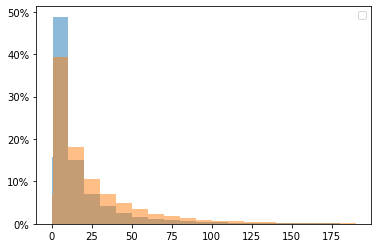

In [237]:
thres1, thres2 = 0, 10000000
fs = [s for s in pc_fs if thres1 <= s <= thres2]
tr = [s for s in pc_tr if thres1 <= s <= thres2]

bins = [0, 1] + [x * 10 for x in range(1, 20)]

plt.legend(loc = 'upper right')
from matplotlib.ticker import PercentFormatter
plt.hist(fs, weights=np.ones(len(fs)) / len(fs), bins = bins, label = 'false', alpha = 0.5)
plt.hist(tr, weights=np.ones(len(tr)) / len(tr), bins = bins, label = 'false', alpha = 0.5)

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


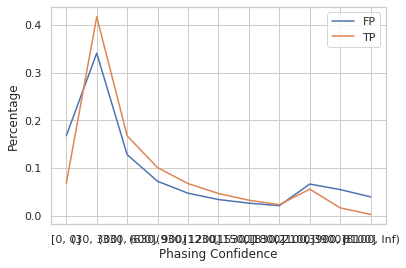

In [321]:
rcParams['font.family'] = 'Arial'
# rcParams['font.sans-serif'] = ['Tahoma']

plt.plot(x_label, fs_plt, label = 'FP')
plt.plot(x_label, tr_plt, label = 'TP')
plt.xlabel('Phasing Confidence')
plt.ylabel('Percentage')
plt.legend(loc = 'best')
plt.show()

AttributeError: 'AxesSubplot' object has no attribute 'show'

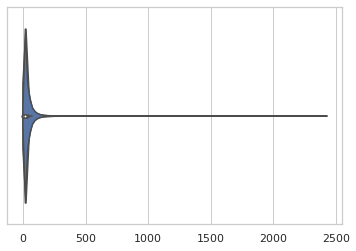

In [291]:
sns.set_theme(style="whitegrid")
# tips = sns.load_dataset("tips")
# ax = sns.violinplot(x=[s for s in pc_fs if s <= 71], cut = 0)
ax1 = sns.violinplot(x=pc_fs)
ax2 = sns.violinplot(x=pc_tr)

In [281]:
x={'tr': pc_tr, 'fs': pc_fs}
pd.DataFrame.from_dict(x)

ValueError: arrays must all be same length

In [ ]:
# outdated read_input

home = '/autofs/bal20/ykzhou/HG00733/'
# aln_file = home + 'aln/HG00733_1_Guppy_4.2.2_prom_8X.bam'
ref_file = '/autofs/bal20/ykzhou/ref/hg38.no_alt.fa'
af_folder = ['snp_8x_025/', 'snp_8x_020/', 'snp_8x_037/', 'snp_8x_012/']
partition_folder = ['pass/', 'thres/', 'all/', 'pileup/']
cutesv_path = home + 'cutesv/cutesv.vcf'
svim_cls09_path = home + 'svim_cls09/variants.vcf'
truth_home = '/autofs/bal20/ykzhou/truthset_vcf/HGSVC2/'
base_vcf_path = truth_home + 'HG00733_mainChr.vcf' # will modify as a list: [HG00733, NA12878, NA24385]
caller_path = {'cutesv': cutesv_path, 'svim_cls09': svim_cls09_path, 'svim': svim_path}

read_hap = dict()
callinfo = dict()
callinfo['base'] = generate_baseinfo(base_vcf_path)

for af in af_folder:
    snp_home = home + af
    phase_home = snp_home + 'phase/'
    callinfo[af] = dict()
    read_hap[af] = dict()
    for partition in partition_folder:
        partition_home = phase_home + partition
        read_hap[af][partition] = read_hap_bam(partition_home)
        callinfo[af][partition] = dict()
        for caller in caller_path:
            callinfo[af][partition][caller] = generate_callinfo(caller, read_hap[af][partition])
        print(partition_home)
        
callstat = dict()
readstat = dict()

callstat['HG00733'] = callinfo
readstat['HG00733'] = read_hap

for af in ['snp_8x_030/', 'snp_8x_015/']:
    snp_home = home + af
    phase_home = snp_home + 'phase/'
    callinfo[af] = dict()
    read_hap[af] = dict()
    for partition in partition_folder:
        partition_home = phase_home + partition
        read_hap[af][partition] = read_hap_bam(partition_home)
        callinfo[af][partition] = dict()
        for caller in caller_path:
            callinfo[af][partition][caller] = generate_callinfo(caller, read_hap[af][partition])
        print(partition_home)
        
sample_home = '/autofs/bal20/ykzhou/' + 'HG00733' + '/'
cutesv_path = sample_home + 'cutesv/cutesv.vcf'
svim_cls09_path = sample_home + 'svim_cls09/variants.vcf'
svim_path = sample_home + 'svim/variants.vcf'
caller_path = {'cutesv': cutesv_path, 'svim_cls09': svim_cls09_path, 'svim': svim_path}

for af in callstat['HG00733']:
    if af != 'base':
        for partition in partition_folder:
#             partition_home = '/autofs/bal20/ykzhou/HG00733/' + af + partition
            callstat['HG00733'][af][partition]['svim'] = \
                generate_callinfo('svim', readstat['HG00733'][af][partition])